In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

%tensorflow_version 1.x
import tensorflow as tf
from keras.layers import Dense, LSTM, Conv1D, Flatten, Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
# if using colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Getting to know the data

In [0]:
df = pd.read_csv('/content/drive/My Drive/__MGR/waterlevel_1989_2018.csv', index_col=0)
#df = pd.read_csv('waterlevel_1989_2018.csv', index_col=0)

In [4]:
df.index = pd.DatetimeIndex(df.index)
df

lvl
1989-01-01 01:00:00   6.0
1989-01-01 02:00:00  18.0
1989-01-01 03:00:00  27.0
1989-01-01 04:00:00  31.0
1989-01-01 05:00:00  34.0
...                   ...
2018-12-31 20:00:00  11.0
2018-12-31 21:00:00   9.0
2018-12-31 22:00:00   3.0
2018-12-31 23:00:00  -3.0
2019-01-01 00:00:00  -7.0

[262968 rows x 1 columns]

In [0]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

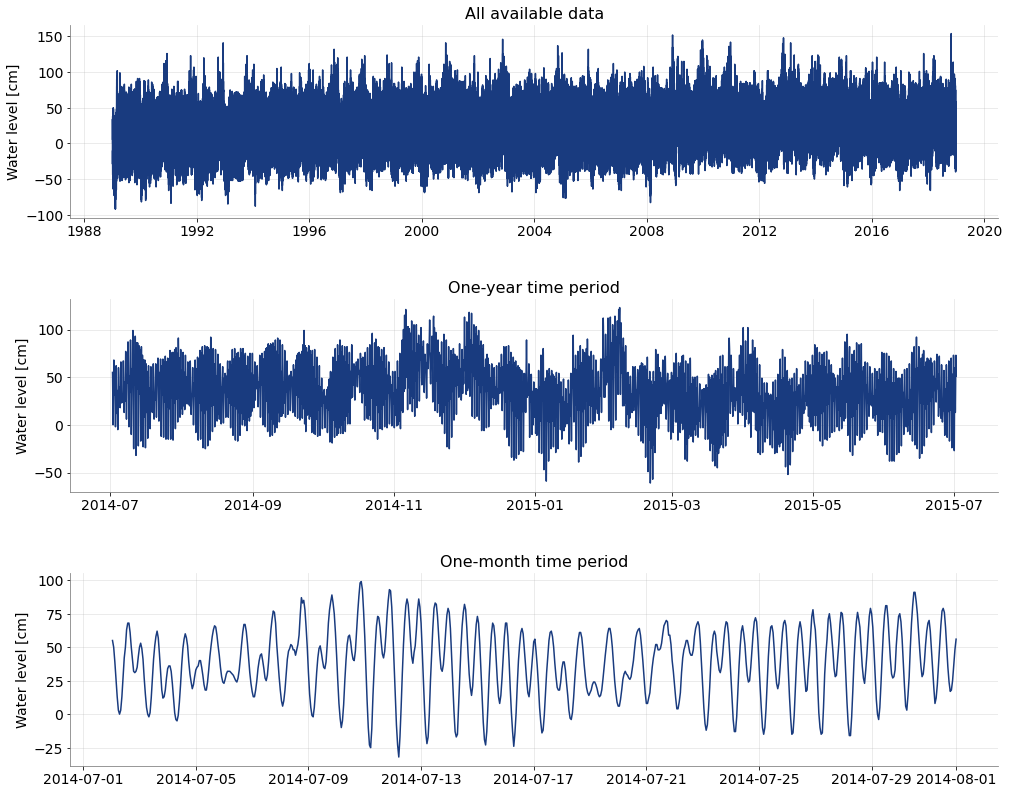

In [0]:
fig, ax = plt.subplots(3,1, figsize=(15, 12))
ax[0].plot(df, color='#193B7F')
ax[0].set_title('All available data')
ax[1].plot(df[223512:223512+365*24], color='#193B7F')
ax[1].set_title('One-year time period')
ax[2].plot(df[223512:223512+30*24], color='#193B7F')
ax[2].set_title('One-month time period')

for ax in [ax[0], ax[1], ax[2]]:
    ax.set_ylabel('Water level [cm]')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color(None)
    ax.spines['left'].set_color('0.5')
    ax.spines['right'].set_color(None)
    ax.grid(alpha=0.3)
fig.tight_layout(pad=3.0)
#plt.savefig('/content/drive/My Drive/__MGR/original_data.pdf')
plt.show()

### Linear trend


In [0]:
from sklearn.linear_model import LinearRegression

time = np.arange(0, len(df))
lvl = df['lvl']
reg = LinearRegression().fit(time.reshape(-1, 1), lvl)

In [0]:
reg.coef_

array([6.86884074e-05])

There's an increasing linear trend.

### Seasonality

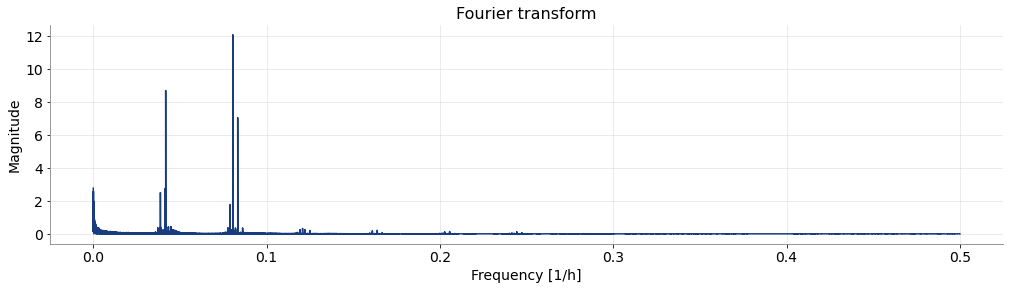

most significant periods obtained - in hours:
 [    12.42055545     23.93446801     12.         262968.
     24.06589183   8765.6            25.8191458  131484.
     11.967234     4382.8            12.65851545  37566.85714286
     12.42114213   7107.24324324  21914.          14609.33333333
     23.93011193   1429.17391304   4108.875          12.41996883
  32871.           5366.69387755   7513.37142857   5843.73333333
     12.42172886  65742.           1891.85611511   4045.66153846
  17531.2          4533.93103448  23906.18181818   1163.57522124
  13148.4            24.           7734.35294118     12.65790614
   2797.53191489   2954.69662921   1511.31034483]
- in days:
 [    0.51752314     0.9972695      0.5        10957.
     1.00274549   365.23333333     1.07579774  5478.5
     0.49863475   182.61666667     0.52743814  1565.28571429
     0.51754759   296.13513514   913.08333333   608.72222222
     0.997088      59.54891304   171.203125       0.5174987
  1369.625        223.6122449    

In [0]:
fft3 = np.fft.rfft(lvl) / len(lvl) #* 2  #normalized (and *2 because using rfft we have just a half of the power)
freqs = np.fft.rfftfreq(len(lvl), 1)

fig, ax = plt.subplots(1,1, figsize=(15, 5))
ax.plot(freqs[1:], np.abs(fft3)[1:], color='#193B7F')
ax.set_title('Fourier transform')
ax.set_xlabel('Frequency [1/h]')
ax.set_ylabel('Magnitude')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color(None)
ax.spines['left'].set_color('0.5')
ax.spines['right'].set_color(None)
ax.grid(alpha=0.3)
fig.tight_layout(pad=3.0)
#plt.savefig('/content/drive/My Drive/__MGR/original_data_fft.pdf')
plt.show()

arg_top = np.abs(fft3).argsort()[-40:-1][::-1]
np.set_printoptions(suppress=True)
print('most significant periods obtained - in hours:\n', 1 / freqs[arg_top])
print('- in days:\n', 1 / freqs[arg_top] / 24)
print('indices:\n', arg_top)


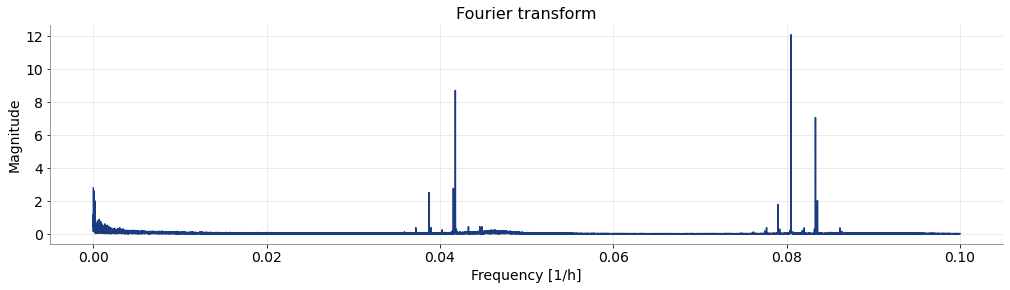

In [0]:
fig, ax = plt.subplots(1,1, figsize=(15, 5))
ax.plot(freqs[1:round(len(freqs)/5)], np.abs(fft3)[1:round(len(freqs)/5)], color='#193B7F')
ax.set_title('Fourier transform')
ax.set_xlabel('Frequency [1/h]')
ax.set_ylabel('Magnitude')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color(None)
ax.spines['left'].set_color('0.5')
ax.spines['right'].set_color(None)
ax.grid(alpha=0.3)
fig.tight_layout(pad=3.0)
plt.savefig('/content/drive/My Drive/__MGR/original_data_fft_zoom.pdf')
plt.show()

Many seasonalities discovered (especially around 12h, 24h, 1 year, half a year)

# Fitting the model to data

## Functions

In [0]:
def create_dataset(dataset, look_back=48, pred_window=12):
    'function to create windows for training'
    'necessary to control time series length in order to obtain full sequences'
    dataX, dataY = [], []
    for i in np.arange(0, len(dataset)-look_back-pred_window, pred_window):   # this -pred_window cuts the last window from the data :(
        a = dataset[i:(i+look_back)]                                          # my bad, but im too lazy to change the rest of the code
        dataX.append(a.reshape(-1,1))
        dataY.append(dataset[(i + look_back):(i + look_back + pred_window)])
    return np.array(dataX), np.array(dataY)

def create_dataset1(dataset, look_back=48, pred_window=12):
    'function to create windows for training'
    'necessary to control time series length in order to obtain full sequences'
    dataX, dataY = [], []
    for i in np.arange(0, len(dataset)-look_back, pred_window):               # this one is good!
        a = dataset[i:(i+look_back)]
        dataX.append(a.reshape(-1,1))
        dataY.append(dataset[(i + look_back):(i + look_back + pred_window)])
    return np.array(dataX), np.array(dataY)

In [0]:
def accuracy(true_test, prediction):
    'function to analyze the results with plots, error measures and frequency check'
        
    window = true_test.shape[1]
    error = true_test.flatten() - prediction.flatten()
    
    fig, [ax1, ax2] = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(18, 4))
    ax1.plot(true_test.flatten()[0:window], color='#193B7F')
    ax1.plot(prediction.flatten()[0:window], color='red')
    ax1.set_title('One prediction window ahead') 
    ax1.set_xlabel('Time [h]')
    ax1.set_ylabel('Value [cm]')
    ax1.legend(['True values', 'Prediction'], loc='lower right')
    
    ax2.scatter(true_test.flatten()[0:window], prediction[0:window], color='#193B7F')
    ax2.plot(true_test.flatten()[0:window], true_test.flatten()[0:window], color='k')
    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted vaue')

    for ax in [ax1, ax2]:
        ax.spines['bottom'].set_color('0.5')
        ax.spines['top'].set_color(None)
        ax.spines['left'].set_color('0.5')
        ax.spines['right'].set_color(None)
        ax.grid(alpha=0.3)
    fig.tight_layout(pad=3.0)
    plt.savefig('/content/drive/My Drive/__MGR/accuracy1.pdf')
    plt.show()
    
    mse = np.mean(error[0:window] ** 2)
    print('Mean squared error for first single window prediction: ', mse)

    
    fig, [ax1, ax2] = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(18, 4))
    ax1.plot(true_test.flatten()[0:720], color='#193B7F')
    ax1.plot(prediction.flatten()[0:720], color='red')
    ax1.set_title('One month ahead') 
    ax1.set_xlabel('Time [h]')
    ax1.set_ylabel('Value [cm]')
    ax1.legend(['True values', 'Prediction'], loc='lower right')
    
    ax2.scatter(true_test.flatten()[0:720], prediction[0:720], color='#193B7F')
    ax2.plot(true_test.flatten()[0:720], true_test.flatten()[0:720], color='k')
    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted vaue')

    for ax in [ax1, ax2]:
        ax.spines['bottom'].set_color('0.5')
        ax.spines['top'].set_color(None)
        ax.spines['left'].set_color('0.5')
        ax.spines['right'].set_color(None)
        ax.grid(alpha=0.3)
    fig.tight_layout(pad=3.0)
    #plt.savefig('/content/drive/My Drive/__MGR/accuracy2.pdf')
    plt.show()
    
    mse = np.mean(error[0:720] ** 2)
    print('Mean squared error for one month prediction: ', mse)
    
    
    fig, [ax1, ax2] = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(18, 4))
    ax1.plot(true_test.flatten()[0:8760], color='#193B7F')
    ax1.plot(prediction.flatten()[0:8760], color='red')
    ax1.set_title('One year ahead') 
    ax1.set_xlabel('Time [h]')
    ax1.set_ylabel('Value [cm]')
    ax1.legend(['True values', 'Prediction'], loc='lower right')
    
    ax2.scatter(true_test.flatten()[0:8760], prediction[0:8760], color='#193B7F')
    ax2.plot(true_test.flatten()[0:8760], true_test.flatten()[0:8760], color='k')
    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted vaue')
    
    for ax in [ax1, ax2]:
        ax.spines['bottom'].set_color('0.5')
        ax.spines['top'].set_color(None)
        ax.spines['left'].set_color('0.5')
        ax.spines['right'].set_color(None)
        ax.grid(alpha=0.3)
    fig.tight_layout(pad=3.0)
    #plt.savefig('/content/drive/My Drive/__MGR/accuracy3.pdf')
    plt.show()
    
    mse = np.mean(error[0:8760] ** 2)
    print('Mean squared error for one year prediction: ', mse)
    
    
    fft3 = np.fft.rfft(prediction) / len(prediction) 
    freqs = np.fft.rfftfreq(len(prediction), 1)

    fig, ax = plt.subplots(1,1, figsize=(15, 5))
    ax.plot(freqs[1:], np.abs(fft3)[1:], color='#193B7F')
    ax.set_xlabel('Frequency [1/hour]')
    ax.set_ylabel('Magnitude')
    ax.set_title('Fourier transform of predicted values')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color(None)
    ax.spines['left'].set_color('0.5')
    ax.spines['right'].set_color(None)
    ax.grid(alpha=0.3)
    fig.tight_layout(pad=3.0)
    #plt.savefig('/content/drive/My Drive/__MGR/pred_fft.pdf')
    plt.show()

    arg_top = np.abs(fft3).argsort()[-25:-1][::-1]
    np.set_printoptions(suppress=True)
    print('most significant periods obtained - in hours:\n', 1 / freqs[arg_top])
    print('- in days:\n', 1 / freqs[arg_top] / 24)
    print('indices:\n', arg_top)

    

In [0]:
def see_between_quantiles(Y_test, predictions_matrix, quantile, caption):
    'quantile analysis, if you set the upper quantile=0.95, then you analyze 90% quantile range, since the lower quantile is set to 0.05'

    lower_quantiles = np.quantile(predictions_matrix, round(1.00-quantile,2), axis=0)
    upper_quantiles = np.quantile(predictions_matrix, quantile, axis=0)
    pred_window = Y_test.shape[1]

    fig, ax = plt.subplots(3, 1, figsize=(15, 12))
    windows = [24, 720, 720*3]
    cap = ['One day ahead', 'One month ahead', 'Three months ahead']

    for i in range(3):
        ax[i].plot(Y_test.flatten()[0:windows[i]], color='#193B7F')
        ax[i].plot(lower_quantiles[0:windows[i]], color='red')
        ax[i].plot(upper_quantiles[0:windows[i]], color='red')
        ax[i].set_title(cap[i]) 
        ax[i].set_xlabel('Time [h]')
        ax[i].set_ylabel('Value [cm]')
        ax[i].legend(['True values', 'Quantiles {low} and {up}\nof prediction'.format(low=round(1-quantile,2), up=quantile)], loc='lower right')
        ax[i].spines['bottom'].set_color('0.5')
        ax[i].spines['top'].set_color(None)
        ax[i].spines['left'].set_color('0.5')
        ax[i].spines['right'].set_color(None)
        ax[i].grid(alpha=0.3)

    fig.tight_layout(pad=3.0)
    plt.savefig('/content/drive/My Drive/__MGR/between_quantiles_{cap}.pdf'.format(cap=caption))
    plt.show()

    print('What part of real values lies between quantile lines:')
    # for one pred window:
    end = pred_window
    print('In the first {pred_window} hours (prediction window): '.format(pred_window=pred_window), np.mean((lower_quantiles[:end] <= Y_test.flatten()[:end]) & (Y_test.flatten()[:end] <= upper_quantiles[:end])))

    end = 12
    print('In the first 12 hours: ', np.mean((lower_quantiles[:end] <= Y_test.flatten()[:end]) & (Y_test.flatten()[:end] <= upper_quantiles[:end])))

    end = 24
    print('In the first 24 hours: ', np.mean((lower_quantiles[:end] <= Y_test.flatten()[:end]) & (Y_test.flatten()[:end] <= upper_quantiles[:end])))

    end = 48
    print('In the first 48 hours: ', np.mean((lower_quantiles[:end] <= Y_test.flatten()[:end]) & (Y_test.flatten()[:end] <= upper_quantiles[:end])))

    # for one month pred:
    end = 720
    print('For the first month: ', np.mean((lower_quantiles[:end] <= Y_test.flatten()[:end]) & (Y_test.flatten()[:end] <= upper_quantiles[:end])))

    # for one year pred:
    end = 8760
    print('For the first year: ', np.mean((lower_quantiles[:end] <= Y_test.flatten()[:end]) & (Y_test.flatten()[:end] <= upper_quantiles[:end])))

    width = upper_quantiles - lower_quantiles
    fig, ax = plt.subplots(1, 1, figsize=(15, 4))
    
    ax.plot(width[0:720], color='#193B7F')
    ax.set_title('Width of {q}% prediction range for 1 month ahead'.format(q=round(100*quantile)))
    ax.set_xlabel('Time [h]')
    ax.set_ylabel('Width [cm]')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color(None)
    ax.spines['left'].set_color('0.5')
    ax.spines['right'].set_color(None)
    ax.grid(alpha=0.3)

    fig.tight_layout(pad=3.0)
    plt.show()

    print('Average width of', 100*quantile, '% predinction range:')
    end = pred_window
    print('In the first {pred_window} hours (prediction window): '.format(pred_window=pred_window), np.mean(width[:end]))
    end = 12
    print('In the first 12 hours: ', np.mean(width[:end]))
    end = 24
    print('In the first 24 hours: ', np.mean(width[:end]))
    end = 48
    print('In the first 48 hours: ', np.mean(width[:end]))
    end = 720
    print('For the first month: ', np.mean(width[:end]))
    end = 8760
    print('For the first year: ', np.mean(width[:end]))


## Scaling data and then fitting

In [9]:
from sklearn.preprocessing import MinMaxScaler
df_scaled = df.copy()
scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaled['lvl'] = scaler.fit_transform(df_scaled[['lvl']])
df_scaled

lvl
1989-01-01 01:00:00 -2.032520e-01
1989-01-01 02:00:00 -1.056911e-01
1989-01-01 03:00:00 -3.252033e-02
1989-01-01 04:00:00  1.110223e-16
1989-01-01 05:00:00  2.439024e-02
...                           ...
2018-12-31 20:00:00 -1.626016e-01
2018-12-31 21:00:00 -1.788618e-01
2018-12-31 22:00:00 -2.276423e-01
2018-12-31 23:00:00 -2.764228e-01
2019-01-01 00:00:00 -3.089431e-01

[262968 rows x 1 columns]

#### starting model

In [0]:
look_back = 48
pred_window = 12
X, Y = create_dataset(np.array(df_scaled['lvl']), look_back=look_back, pred_window=pred_window)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, shuffle=False)

In [11]:
# to calculate number of parameters in LSTM layer
n = 36   # number of cells and size of the history h_{t-1}
m = 48    # size of the input x_t
4 * (n * (n + m + 1))

12240

In [12]:
300/25

12.0

In [0]:
batch = 64

model_many_epochs = Sequential()
model_many_epochs.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
model_many_epochs.add(LSTM(24, return_sequences=True))
model_many_epochs.add(LSTM(24))
model_many_epochs.add(Dense(pred_window))

model_many_epochs.compile(optimizer='adam', loss='mean_squared_error')
model_many_epochs.summary()

model_many_epochs.fit(X_train, Y_train, batch_size=batch, epochs=200, validation_data=(X_test, Y_test))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 48, 48)            9600      
_________________________________________________________________
lstm_2 (LSTM)                (None, 48, 24)            7008      
_________________________________________________________________
lstm_3 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                300       
Total params: 21,612
Trainable params: 21,612
Non-trainable params: 0
_________________________________________________________________

Train on 18622 samples, validate on 3287 samples
Epoch 1/200
18622/18622 [==============================] - 24s 1ms/step - loss: 0.0266 - val_loss: 0.0144
Epoch 2/200

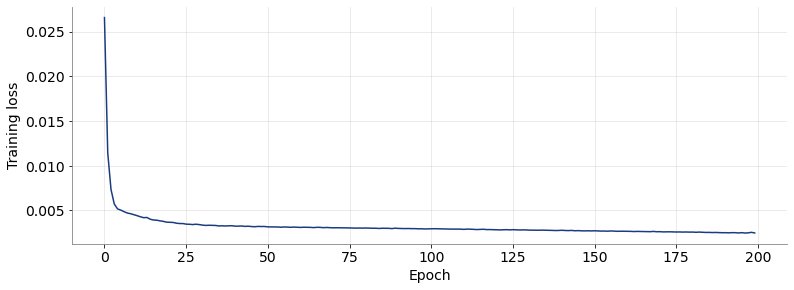

In [0]:
fig, ax = plt.subplots(1,1, figsize=(12, 5))
ax.plot(model_many_epochs.history.history['loss'], color='#193B7F')
ax.set_ylabel('Training loss')
ax.set_xlabel('Epoch')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color(None)
ax.spines['left'].set_color('0.5')
ax.spines['right'].set_color(None)
ax.grid(alpha=0.3)
fig.tight_layout(pad=3.0)
#plt.savefig('/content/drive/My Drive/__MGR/loss_epochs.pdf')
#np.savetxt('/content/drive/My Drive/__MGR/training_loss_200ep_64batch.csv'.format(k=k), model_many_epochs.history.history['loss'], delimiter=',', fmt='%10.5f')
plt.show()

In [0]:
# many optimizers

batch = 64
optim = ['adam', 'Adagrad', 'RMSprop', 'sgd', 'Adadelta', 'Adamax', 'Nadam']
losses_optim = np.zeros((7,70))

for i in range(4,7):
    model_many_epochs = Sequential()
    model_many_epochs.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_many_epochs.add(LSTM(24, return_sequences=True))
    model_many_epochs.add(LSTM(24))
    model_many_epochs.add(Dense(pred_window))

    model_many_epochs.compile(optimizer=optim[i], loss='mean_squared_error')
    model_many_epochs.summary()
    model_many_epochs.fit(X_train, Y_train, batch_size=batch, epochs=70, validation_data=(X_test, Y_test))

    losses_optim[i] = model_many_epochs.history.history['loss']

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 48, 48)            9600      
_________________________________________________________________
lstm_2 (LSTM)                (None, 48, 24)            7008      
_________________________________________________________________
lstm_3 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                300       
Total params: 21,612
Trainable params: 21,612
Non-trainable params: 0
_________________________________________________________________



Train on 18622 samples, validate on 3287 samples
Epoch 1/70
18622/18622 [==============================] - 23s 1ms/step - loss: 0.0412 - val_loss: 0.0302
Epoch 2/70
18622/18622 [==============================] - 22s 1ms/step - loss: 0.0291 - val_loss: 0.0265
Epoch 3/70
18622/18622 [==============================] - 23s 1ms/step - loss: 0.0234 - val_loss: 0.0205
Epoch 4/70
18622/18622 [==============================] - 23s 1ms/step - loss: 0.0172 - val_loss: 0.0153
Epoch 5/70
18622/18622 [==============================] - 23s 1ms/step - loss: 0.0124 - val_loss: 0.0089
Epoch 6/70
18622/18622 [==============================] - 23s 1ms/step - loss: 0.0095 - val_loss: 0.0085
Epoch 7/70
18622/18622 [==============================] - 23s 1ms/step - loss: 0.0083 - val_loss: 0.0091
Epoch 8/70
18622/18622 [==============================] - 23s 1ms/step - loss: 0.0075 - val_loss: 0.0060
Epoch 9/70
18622/18622 [==============================] - 23s 1ms/step - loss: 0.0070 - val_loss: 0.0058
Epoch 

In [0]:
for i in range(4,7):
  np.savetxt('/content/drive/My Drive/__MGR/loss_{optim}.csv'.format(optim=optim[i]), losses_optim[i], delimiter=',', fmt='%10.5f')

In [0]:
for i in range(7):
    losses_optim[i] = np.genfromtxt('/content/drive/My Drive/__MGR/loss_{optim}.csv'.format(optim=optim[i]), delimiter=',')

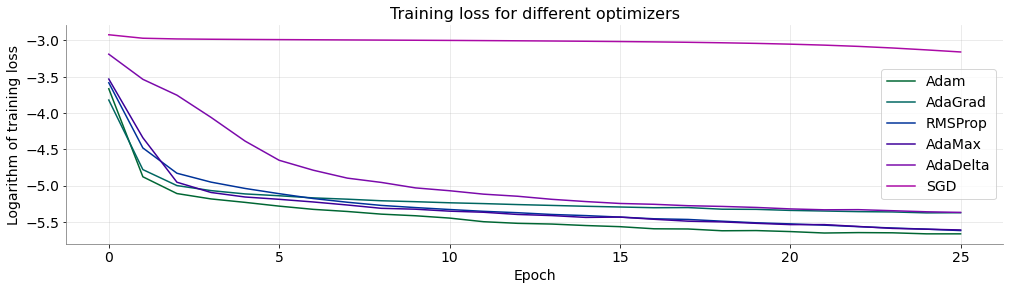

In [0]:
optim = ['Adam', 'AdaGrad', 'RMSProp', 'SGD', 'AdaDelta', 'AdaMax', 'Nadam']
fig, ax = plt.subplots(1,1, figsize=(15, 5))
cols = ['#006633','#006661','#003399','#AB0AA6','#7B0AAB','#3D0099']
for i in [0,1,2,5,4,3]:
    plt.plot(np.log(losses_optim[i][:26]), color=cols[i])
ax.set_title('Training loss for different optimizers')
ax.set_xlabel('Epoch')
ax.set_ylabel('Logarithm of training loss')
ax.legend(np.array(optim)[[0,1,2,5,4,3]])
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color(None)
ax.spines['left'].set_color('0.5')
ax.spines['right'].set_color(None)
ax.grid(alpha=0.3)
fig.tight_layout(pad=3.0)
plt.savefig('/content/drive/My Drive/__MGR/loss_optimizers.pdf')
plt.show()

In [0]:
# producing multiple models and their predictions to see the quantile lines later
batch = 64
 
for k in range(50,60):
    model_12 = Sequential()
    model_12.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_12.add(LSTM(24, return_sequences=True))
    model_12.add(LSTM(24))
    model_12.add(Dense(pred_window))
 
    model_12.compile(optimizer='adam', loss='mean_squared_error')
    model_12.fit(X_train, Y_train, batch_size=batch, epochs=20, validation_data=(X_test, Y_test))
 
    pred_12 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_12.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_12 = np.append(pred_12, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window12_scaled/{k}.csv'.format(k=k), pred_12, delimiter=',', fmt='%10.5f')

In [0]:
scaler.inverse_transform(Y_test)

array([[55., 50., 39., ..., 27., 42., 50.],
       [63., 68., 68., ..., 35., 43., 50.],
       [53., 49., 41., ..., 12., 27., 41.],
       ...,
       [19., 31., 42., ..., 13.,  8.,  1.],
       [ 0.,  0.,  2., ..., -4., -6., -4.],
       [ 0.,  9., 20., ..., 22.,  7., -4.]])

In [0]:
predictions12_scaled = np.zeros((50,Y_test.shape[0]*Y_test.shape[1]))
for k in range(50):
    predictions12_scaled[k] = scaler.inverse_transform(np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window12_scaled/{k}.csv'.format(k=k), delimiter=',').reshape(-1, 1)).flatten()

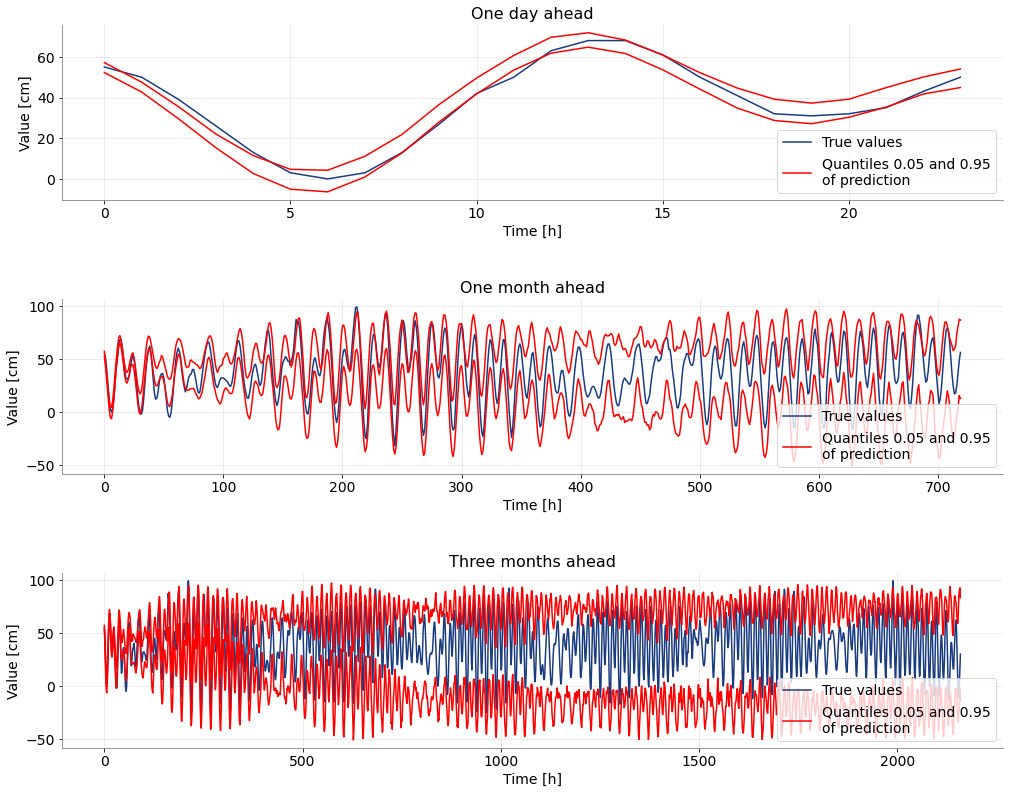

What part of real values lies between quantile lines:
In the first 12 hours (prediction window):  0.5
In the first 12 hours:  0.5
In the first 24 hours:  0.6666666666666666
In the first 48 hours:  0.5416666666666666
For the first month:  0.8888888888888888
For the first year:  0.9140410958904109


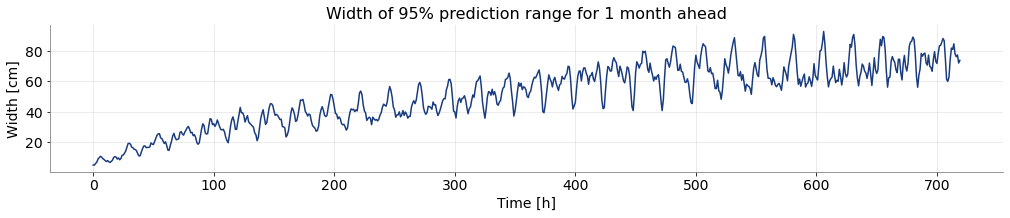

Average width of 95.0 % predinction range:
In the first 12 hours (prediction window):  7.869852624999999
In the first 12 hours:  7.869852624999999
In the first 24 hours:  8.234888437499999
In the first 48 hours:  11.717445093749996
For the first month:  50.85973799791665
For the first year:  91.97796963356161


In [0]:
see_between_quantiles(scaler.inverse_transform(Y_test), predictions12_scaled, 0.95, 'starting_model')

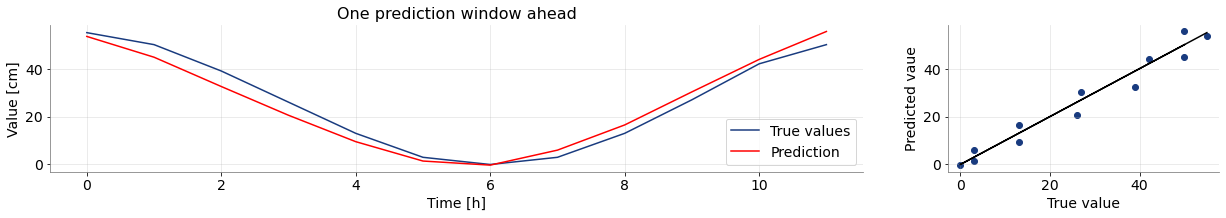

Mean squared error for first single window prediction:  15.157973223200012


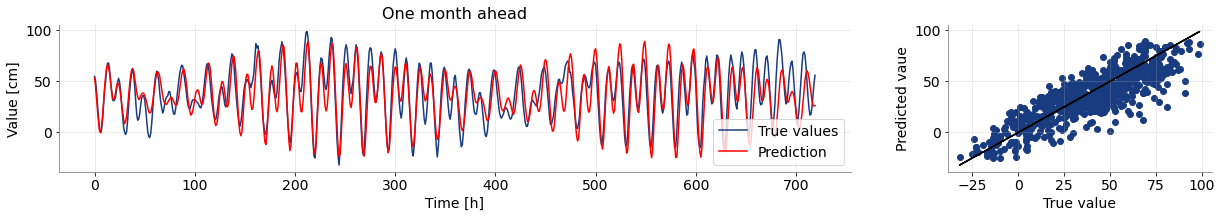

Mean squared error for one month prediction:  204.1396283037853


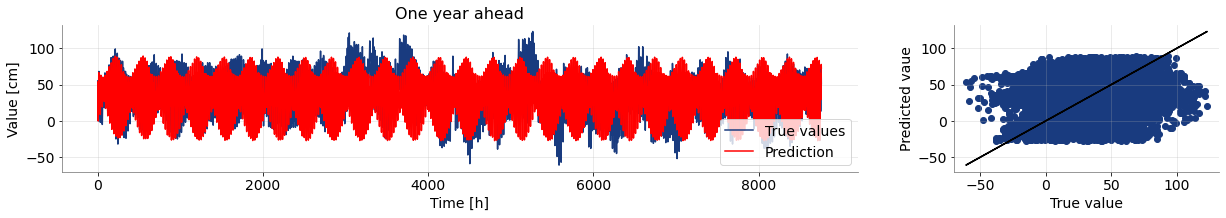

Mean squared error for one year prediction:  1200.2733176598294


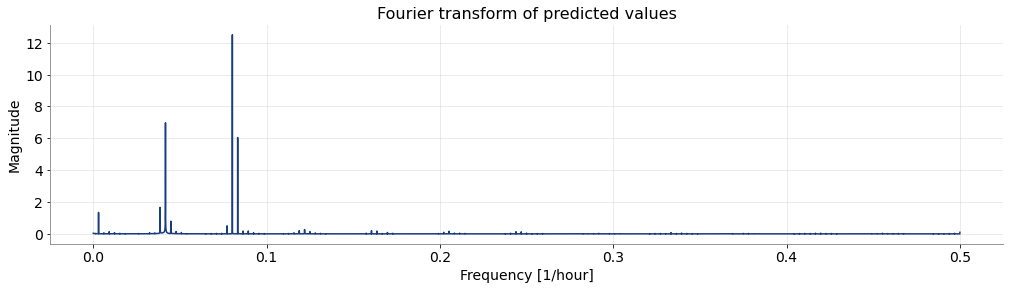

most significant periods obtained - in hours:
 [ 12.45862287  23.99270073  24.00730371  12.          23.9781155
  24.02192448  25.91590013  25.89888378  23.963548    24.03656307
 325.98347107  23.94899818  24.05121951  22.34787535  23.93446602
  24.06589384  22.36054422  23.91995149  24.08058608  25.88188976
  25.93293886  23.90545455  24.09529627  12.95369458]
- in days:
 [ 0.51910929  0.99969586  1.00030432  0.5         0.99908815  1.00091352
  1.07982917  1.07912016  0.99848117  1.00152346 13.58264463  0.99787492
  1.00213415  0.93116147  0.99726942  1.00274558  0.93168934  0.99666465
  1.00335775  1.07841207  1.08053912  0.99606061  1.00397068  0.53973727]
indices:
 [3166 1644 1643 3287 1645 1642 1522 1523 1646 1641  121 1647 1640 1765
 1648 1639 1764 1649 1638 1524 1521 1650 1637 3045]


In [0]:
# one prediction
accuracy(scaler.inverse_transform(Y_test), predictions12_scaled[8])

##### predictions based on true data
not updated by each prediction

In [13]:
batch = 64
 
model_12 = Sequential()
model_12.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
model_12.add(LSTM(24, return_sequences=True))
model_12.add(LSTM(24))
model_12.add(Dense(pred_window))
 
model_12.compile(optimizer='adam', loss='mean_squared_error')
model_12.fit(X_train, Y_train, batch_size=batch, epochs=20, validation_data=(X_test, Y_test))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 18622 samples, validate on 3287 samples
Epoch 1/20
18622/18622 [==============================] - 24s 1ms/step - loss: 0.0264 - val_loss: 0.0115
Epoch 2/20
18622/18622 [==============================] - 23s 1ms/step - loss: 0.0076 - val_loss: 0.0062
Epoch 3/20
18622/18622 [==============================] - 23s 1ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 4/20
18622/18622 [==============================] - 23s 1ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 5/20
18622/18622 [==============================] - 23s 1ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 6/20
18622/18622 [==============================] - 23s 1ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 7/20
18622/18622 [==============================] - 23s 1ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 8/20
18622/18622 [==============================] - 23s 1ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 9/20
18622/18622 [=====

In [0]:
pred_on_true_history = model_12.predict(X_test)

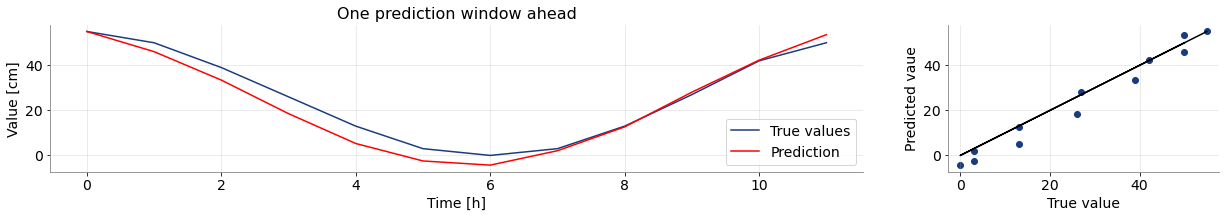

Mean squared error for first single window prediction:  18.740932630498424


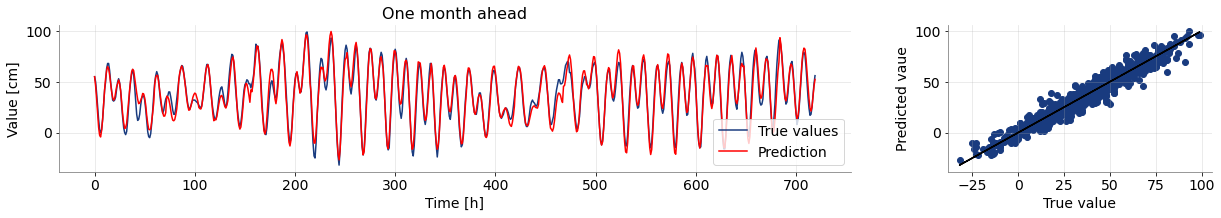

Mean squared error for one month prediction:  36.198496694096015


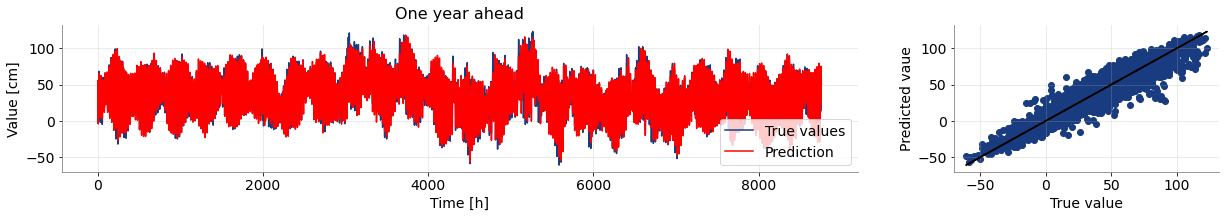

Mean squared error for one year prediction:  62.51885825539544


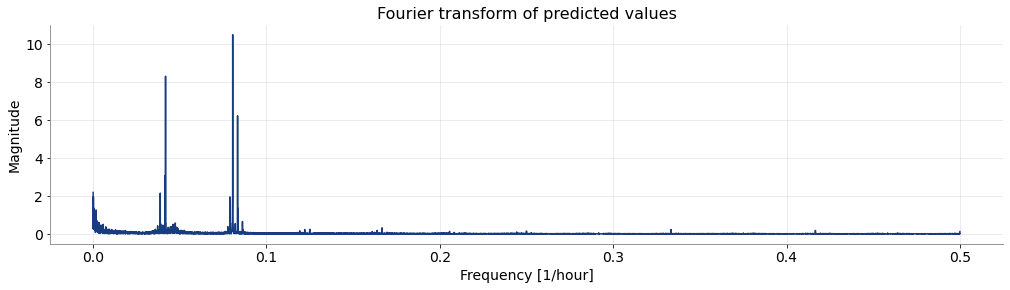

most significant periods obtained - in hours:
 [   12.41939547    23.93446602    12.            12.42330709
    24.06589384    12.41548631 39444.            25.81413613
  5634.85714286    12.65853659    12.42722117 13148.
    12.41157961  7888.8           11.96723301  1972.2
  2191.33333333  3034.15384615   580.05882353  1460.88888889
    12.43113772  2465.25         986.1         9861.        ]
- in days:
 [   0.51747481    0.99726942    0.5           0.5176378     1.00274558
    0.51731193 1643.5           1.07558901  234.78571429    0.52743902
    0.51780088  547.83333333    0.51714915  328.7           0.49863471
   82.175        91.30555556  126.42307692   24.16911765   60.87037037
    0.51796407  102.71875      41.0875      410.875     ]
indices:
 [3176 1648 3287 3175 1639 3177    1 1528    7 3116 3174    3 3178    5
 3296   20   18   13   68   27 3173   16   40    4]


In [17]:
accuracy(scaler.inverse_transform(Y_test), scaler.inverse_transform(pred_on_true_history).flatten())

##### training the model after each prediction

In [0]:
look_back = 12
pred_window = 1
train = np.array(df_scaled[:223512]['lvl'])
test = np.array(df_scaled[(223512-look_back):]['lvl'])

In [0]:
windows_number = 5
pred_online = np.zeros((windows_number,pred_window))
x = np.expand_dims(test[:look_back].reshape(-1,1), axis=0)

In [0]:
for i in range(windows_number):
    print('Step', i)
    X_train, Y_train = create_dataset1(train, look_back=look_back, pred_window=pred_window)

    model_online = Sequential()
    model_online.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_online.add(LSTM(24, return_sequences=True))
    model_online.add(LSTM(24))
    model_online.add(Dense(pred_window))
 
    model_online.compile(optimizer='adam', loss='mean_squared_error')
    model_online.fit(X_train, Y_train, batch_size=64, epochs=10)

    p = model_online.predict(x)
    x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
    pred_online[i] = p
    train = np.append(train, p)
    

Step 0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/10
223500/223500 [==============================] - 69s 309us/step - loss: 0.0032
Epoch 2/10
223500/223500 [==============================] - 68s 304us/step - loss: 4.4911e-04
Epoch 3/10
223500/223500 [==============================] - 68s 306us/step - loss: 4.1853e-04
Epoch 4/10
223500/223500 [==============================] - 68s 306us/step - loss: 4.0794e-04
Epoch 5/10
223500/223500 [==============================] - 69s 307us/step - loss: 4.0081e-04
Epoch 6/10
223500/223500 [==============================] - 68s 305us/step - loss: 3.9250e-04
Epoch 7/10
223500/223500 [==============================] - 69s 308us/step - loss: 3.8799e-04
Epoch 8/10
223500/223500 [==============================] - 69s 309us/step - loss: 3.8625e-04
Epoch 9/10
223500/223500 [==============================] - 69s 307us/step - loss: 3.8158e-04
Epoch 10/10
223500/223500 [==============================] - 69s 309u

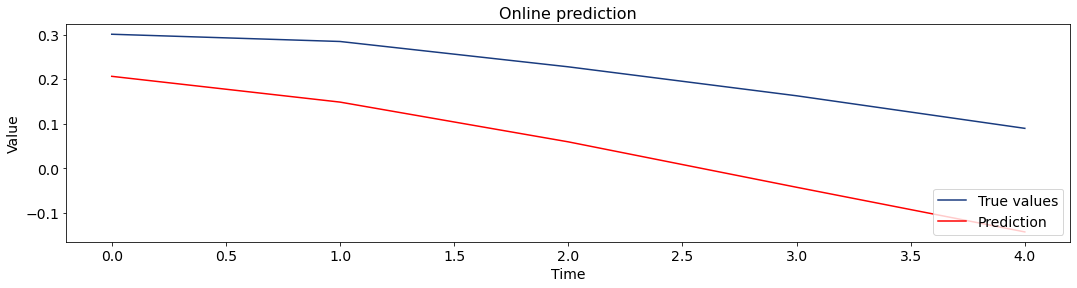

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(18, 4))
ax.plot(test[0:pred_window*windows_number], color='#193B7F')
ax.plot(pred_online.flatten(), color='red')
ax.set_title('Online prediction') 
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend(['True values', 'Prediction'], loc='lower right')

#### model with dropout

In [0]:
look_back = 48
pred_window = 12
X, Y = create_dataset(np.array(df_scaled['lvl']), look_back=look_back, pred_window=pred_window)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, shuffle=False)

In [0]:
batch = 64
 
for k in range(13,50):
    model_12 = Sequential()
    model_12.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_12.add(LSTM(24, return_sequences=True))
    model_12.add(Dropout(0.5))
    model_12.add(LSTM(24))
    model_12.add(Dense(pred_window))
 
    model_12.compile(optimizer='adam', loss='mean_squared_error')
    model_12.fit(X_train, Y_train, batch_size=batch, epochs=20, validation_data=(X_test, Y_test))
 
    pred_12 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_12.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_12 = np.append(pred_12, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_dropout/{k}.csv'.format(k=k), pred_12, delimiter=',', fmt='%10.5f')
    

Train on 18622 samples, validate on 3287 samples
Epoch 1/20
18622/18622 [==============================] - 28s 2ms/step - loss: 0.0286 - val_loss: 0.0100
Epoch 2/20
18622/18622 [==============================] - 25s 1ms/step - loss: 0.0089 - val_loss: 0.0066
Epoch 3/20
18622/18622 [==============================] - 25s 1ms/step - loss: 0.0072 - val_loss: 0.0055
Epoch 4/20
18622/18622 [==============================] - 26s 1ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 5/20
18622/18622 [==============================] - 25s 1ms/step - loss: 0.0062 - val_loss: 0.0053
Epoch 6/20
18622/18622 [==============================] - 26s 1ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 7/20
18622/18622 [==============================] - 26s 1ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 8/20
18622/18622 [==============================] - 26s 1ms/step - loss: 0.0057 - val_loss: 0.0048
Epoch 9/20
18622/18622 [==============================] - 26s 1ms/step - loss: 0.0057 - val_loss: 0.0046
Epoch 

In [0]:
predictions12_scaled_dropout = np.zeros((50,Y_test.shape[0]*Y_test.shape[1]))
for k in range(50):
    predictions12_scaled_dropout[k] = np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_dropout/{k}.csv'.format(k=k), delimiter=',')

predictions12_scaled_dropout = scaler.inverse_transform(predictions12_scaled_dropout)

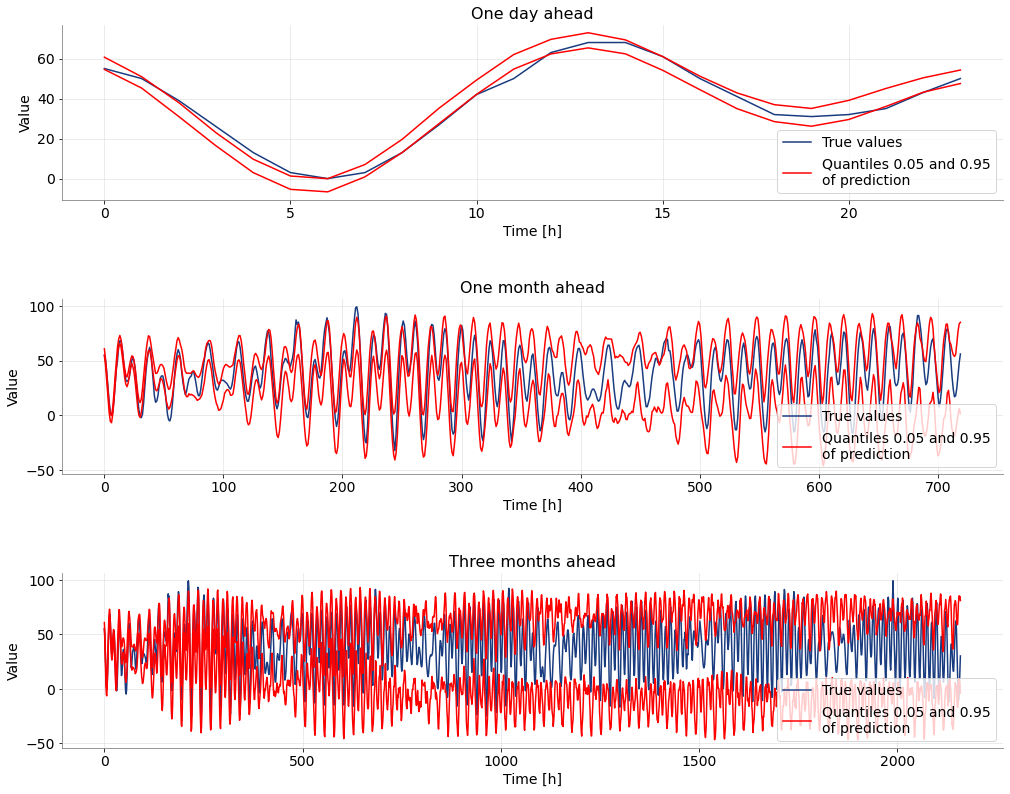

What part of real values lies between quantile lines:
In the first 12 hours (prediction window):  0.25
In the first 12 hours:  0.25
In the first 24 hours:  0.5
In the first 48 hours:  0.4583333333333333
For the first month:  0.8444444444444444
For the first year:  0.8392694063926941


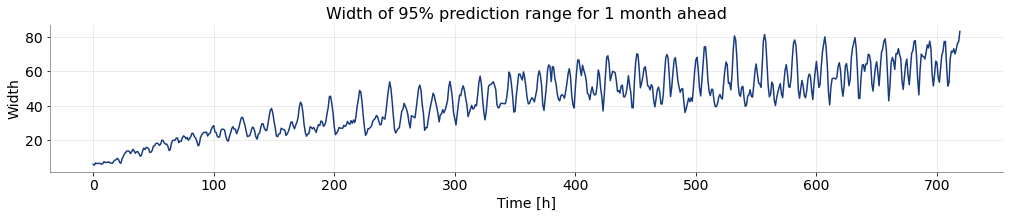

Average width of 95.0 % predinction range:
In the first 12 hours (prediction window):  6.675373999999994
In the first 12 hours:  6.675373999999994
In the first 24 hours:  7.218590687499997
In the first 48 hours:  10.260393499999994
For the first month:  43.085370102083324
For the first year:  79.17322875017122


In [0]:
see_between_quantiles(scaler.inverse_transform(Y_test), predictions12_scaled_dropout, 0.95)

#### model with two layers only

In [0]:
batch = 64

for k in range(50,51):
    model_12 = Sequential()
    model_12.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_12.add(LSTM(36))
    model_12.add(Dense(pred_window))

    model_12.compile(optimizer='adam', loss='mean_squared_error')
    model_12.summary()
    model_12.fit(X_train, Y_train, batch_size=batch, epochs=23, validation_data=(X_test, Y_test))

    pred_12 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_12.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_12 = np.append(pred_12, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_a/{k}.csv'.format(k=k), pred_12, delimiter=',', fmt='%10.5f')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 48, 48)            9600      
_________________________________________________________________
lstm_4 (LSTM)                (None, 36)                12240     
_________________________________________________________________
dense_2 (Dense)              (None, 12)                444       
Total params: 22,284
Trainable params: 22,284
Non-trainable params: 0
_________________________________________________________________
Train on 18622 samples, validate on 3287 samples
Epoch 1/23
18622/18622 [==============================] - 19s 994us/step - loss: 0.0257 - val_loss: 0.0065
Epoch 2/23
18622/18622 [==============================] - 18s 968us/step - loss: 0.0053 - val_loss: 0.0046
Epoch 3/23
 1216/18622 [>.............................] - ETA: 15s - loss: 0.0048

KeyboardInterrupt: ignored

In [0]:
predictions12_scaled_a = np.zeros((50,Y_test.shape[0]*Y_test.shape[1]))
for k in range(50):
    predictions12_scaled_a[k] = np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_a/{k}.csv'.format(k=k), delimiter=',')

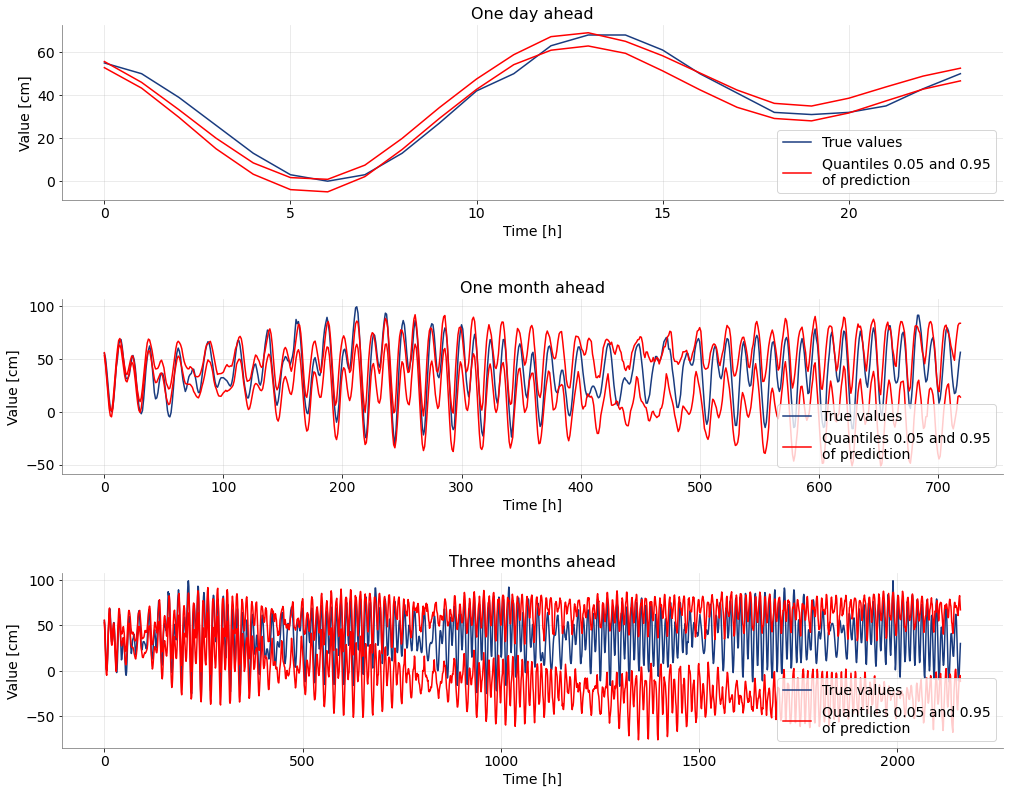

What part of real values lies between quantile lines:
In the first 12 hours (prediction window):  0.25
In the first 12 hours:  0.25
In the first 24 hours:  0.5
In the first 48 hours:  0.3958333333333333
For the first month:  0.825
For the first year:  0.8639269406392694


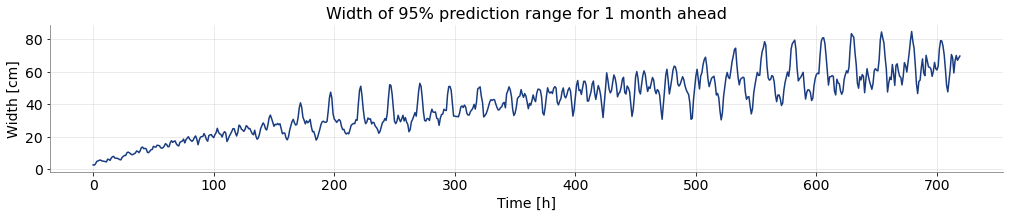

Average width of 95.0 % predinction range:
In the first 12 hours (prediction window):  4.639436999999998
In the first 12 hours:  4.639436999999998
In the first 24 hours:  5.660795687499996
In the first 48 hours:  8.112090874999998
For the first month:  40.80235283749998
For the first year:  90.88021796986298


In [0]:
see_between_quantiles(scaler.inverse_transform(Y_test), scaler.inverse_transform(predictions12_scaled_a), 0.95, '2_layers')

#### model with four layers

In [0]:
look_back = 48
pred_window = 12
X, Y = create_dataset(np.array(df_scaled['lvl']), look_back=look_back, pred_window=pred_window)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, shuffle=False)

In [0]:
batch = 64

for k in range(40,50):
    model_12 = Sequential()
    model_12.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_12.add(LSTM(24, return_sequences=True))
    model_12.add(LSTM(24, return_sequences=True))
    model_12.add(LSTM(12))
    model_12.add(Dense(pred_window))

    model_12.compile(optimizer='adam', loss='mean_squared_error')
    model_12.fit(X_train, Y_train, batch_size=batch, epochs=25, validation_data=(X_test, Y_test))

    pred_12 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_12.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_12 = np.append(pred_12, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_b/{k}.csv'.format(k=k), pred_12, delimiter=',', fmt='%10.5f')

Train on 18622 samples, validate on 3287 samples
Epoch 1/25
18622/18622 [==============================] - 45s 2ms/step - loss: 0.0267 - val_loss: 0.0086
Epoch 2/25
18622/18622 [==============================] - 39s 2ms/step - loss: 0.0076 - val_loss: 0.0062
Epoch 3/25
18622/18622 [==============================] - 38s 2ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 4/25
18622/18622 [==============================] - 39s 2ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 5/25
18622/18622 [==============================] - 38s 2ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 6/25
18622/18622 [==============================] - 38s 2ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 7/25
18622/18622 [==============================] - 38s 2ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 8/25
18622/18622 [==============================] - 38s 2ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 9/25
18622/18622 [==============================] - 38s 2ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 

In [0]:
predictions12_scaled_b = np.zeros((49,Y_test.shape[0]*Y_test.shape[1]))
for k in range(49):
    predictions12_scaled_b[k] = np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_b/{k}.csv'.format(k=k), delimiter=',')


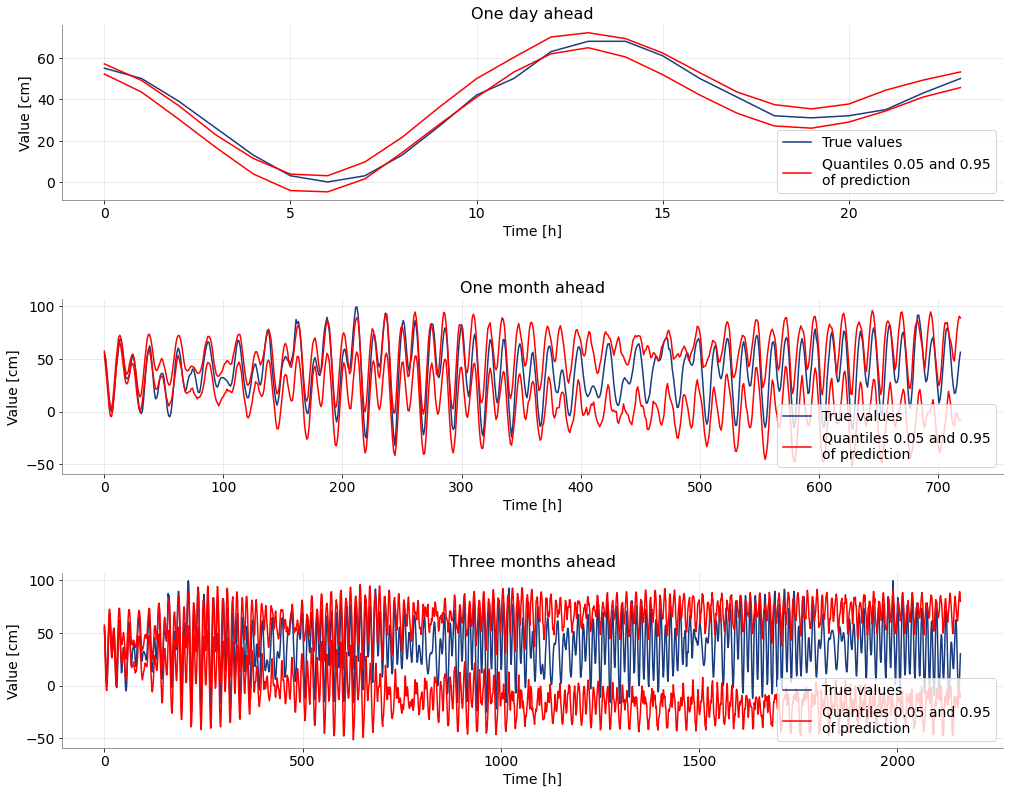

What part of real values lies between quantile lines:
In the first 12 hours (prediction window):  0.4166666666666667
In the first 12 hours:  0.4166666666666667
In the first 24 hours:  0.7083333333333334
In the first 48 hours:  0.5833333333333334
For the first month:  0.8680555555555556
For the first year:  0.8696347031963471


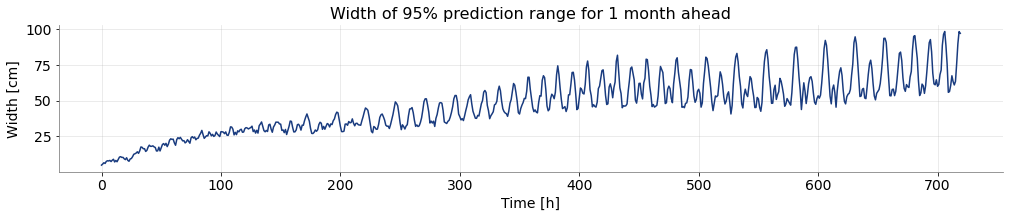

Average width of 95.0 % predinction range:
In the first 12 hours (prediction window):  7.190149499999997
In the first 12 hours:  7.190149499999997
In the first 24 hours:  8.175574249999997
In the first 48 hours:  11.637342624999995
For the first month:  46.596045241666644
For the first year:  84.25880544589039


In [0]:
see_between_quantiles(scaler.inverse_transform(Y_test), scaler.inverse_transform(predictions12_scaled_b), 0.95)

#### model with 6 layers

In [0]:
look_back = 48
pred_window = 12
X, Y = create_dataset(np.array(df_scaled['lvl']), look_back=look_back, pred_window=pred_window)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, shuffle=False)

In [0]:
batch = 64

for k in range(14,50):
    model_12 = Sequential()
    model_12.add(LSTM(64, input_shape=(look_back,1), return_sequences=True))
    model_12.add(LSTM(64, return_sequences=True))
    model_12.add(LSTM(32, return_sequences=True))
    model_12.add(LSTM(24, return_sequences=True))
    model_12.add(LSTM(12))
    model_12.add(Dense(pred_window))

    model_12.compile(optimizer='adam', loss='mean_squared_error')
    model_12.summary()
    model_12.fit(X_train, Y_train, batch_size=batch, epochs=20, validation_data=(X_test, Y_test))

    pred_12 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_12.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_12 = np.append(pred_12, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_c/{k}.csv'.format(k=k), pred_12, delimiter=',', fmt='%10.5f')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 48, 64)            16896     
_________________________________________________________________
lstm_2 (LSTM)                (None, 48, 64)            33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 48, 32)            12416     
_________________________________________________________________
lstm_4 (LSTM)                (None, 48, 24)            5472      
_________________________________________________________________
lstm_5 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
Total params: 69,740
Trainable params: 

KeyboardInterrupt: ignored

In [0]:
predictions12_scaled_c = np.zeros((46,Y_test.shape[0]*Y_test.shape[1]))
for k in range(46):
    predictions12_scaled_c[k] = np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_c/{k}.csv'.format(k=k), delimiter=',')
 

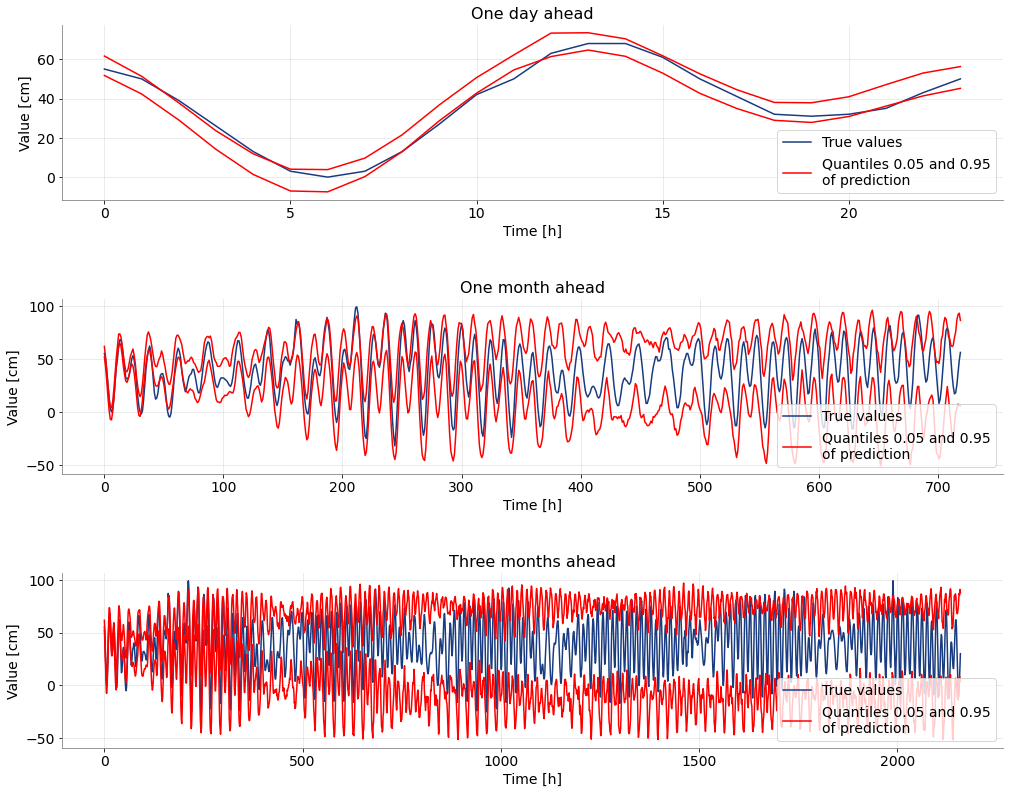

What part of real values lies between quantile lines:
In the first 12 hours (prediction window):  0.5
In the first 12 hours:  0.5
In the first 24 hours:  0.7083333333333334
In the first 48 hours:  0.5833333333333334
For the first month:  0.9013888888888889
For the first year:  0.8785388127853881


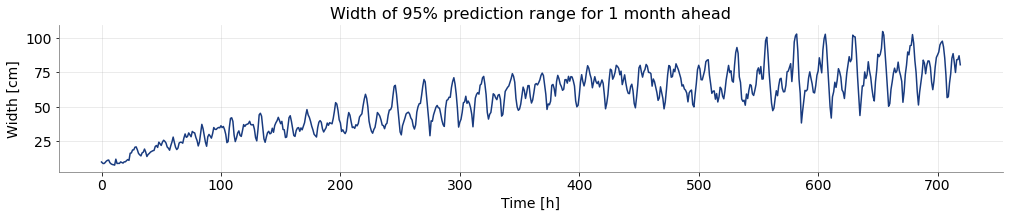

Average width of 95.0 % predinction range:
In the first 12 hours (prediction window):  9.296724375000002
In the first 12 hours:  9.296724375000002
In the first 24 hours:  9.682419062500001
In the first 48 hours:  13.706940625
For the first month:  53.98691741666666
For the first year:  85.24234676541096


In [0]:
see_between_quantiles(scaler.inverse_transform(Y_test), scaler.inverse_transform(predictions12_scaled_c), 0.95)

#### model with 7 layers

In [0]:
look_back = 48
pred_window = 12
X, Y = create_dataset(np.array(df_scaled['lvl']), look_back=look_back, pred_window=pred_window)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, shuffle=False)

In [0]:
# to calculate number of parameters in LSTM layer
n = 96   # number of cells and size of the history h_{t-1}
m = 1    # size of the input x_t
4 * (n * (n + m + 1))

37632

In [0]:
batch = 64

for k in range(34,50):
    model_12 = Sequential()
    model_12.add(LSTM(96, input_shape=(look_back,1), return_sequences=True))
    model_12.add(LSTM(64, return_sequences=True))
    model_12.add(LSTM(64, return_sequences=True))
    model_12.add(LSTM(32, return_sequences=True))
    model_12.add(LSTM(24, return_sequences=True))
    model_12.add(LSTM(24, return_sequences=True))
    model_12.add(LSTM(12))
    model_12.add(Dense(pred_window))

    model_12.compile(optimizer='adam', loss='mean_squared_error')
    model_12.summary()
    model_12.fit(X_train, Y_train, batch_size=batch, epochs=25, validation_data=(X_test, Y_test))

    pred_12 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_12.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_12 = np.append(pred_12, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_d/{k}.csv'.format(k=k), pred_12, delimiter=',', fmt='%10.5f')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 48, 96)            37632     
_________________________________________________________________
lstm_2 (LSTM)                (None, 48, 64)            41216     
_________________________________________________________________
lstm_3 (LSTM)                (None, 48, 64)            33024     
_________________________________________________________________
lstm_4 (LSTM)                (None, 48, 32)            12416     
_________________________________________________________________
lstm_5 (LSTM)                (None, 48, 24)            5472      
_________________________________________________________________
lstm_6 (LSTM)                (None, 48, 24)            4704      
_______________________________________

In [0]:
predictions12_scaled_d = np.zeros((50,Y_test.shape[0]*Y_test.shape[1]))
for k in range(50):
    predictions12_scaled_d[k] = np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_d/{k}.csv'.format(k=k), delimiter=',')
 

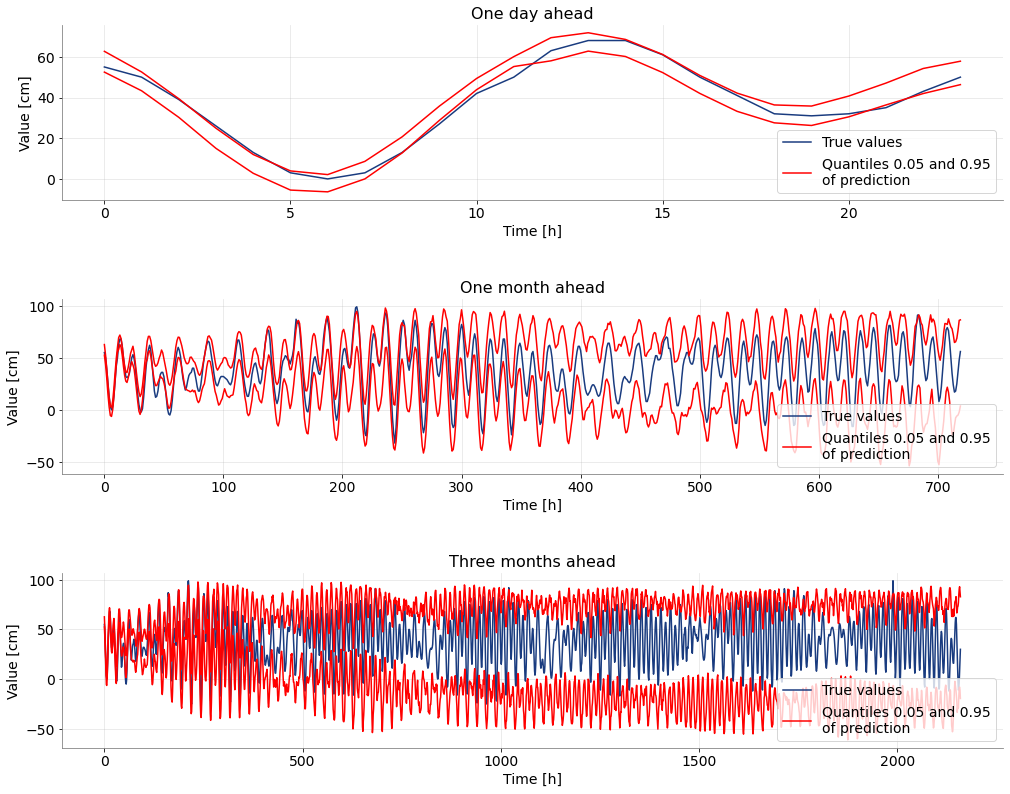

What part of real values lies between quantile lines:
In the first 12 hours (prediction window):  0.5833333333333334
In the first 12 hours:  0.5833333333333334
In the first 24 hours:  0.75
In the first 48 hours:  0.6458333333333334
For the first month:  0.9263888888888889
For the first year:  0.9269406392694064


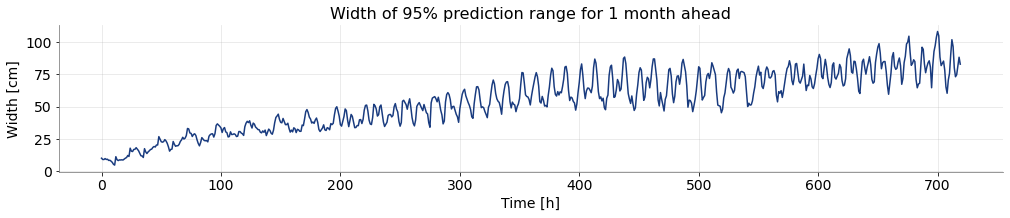

Average width of 95.0 % predinction range:
In the first 12 hours (prediction window):  8.294253875
In the first 12 hours:  8.294253875
In the first 24 hours:  9.087134937499998
In the first 48 hours:  12.708110156249996
For the first month:  54.218720227083324
For the first year:  98.49713340188354


In [0]:
see_between_quantiles(scaler.inverse_transform(Y_test), scaler.inverse_transform(predictions12_scaled_d), 0.95, '8_layers')

### Predict only one future observation (3 layer nn)


In [0]:
look_back = 12
pred_window = 1
train = df_scaled[:223512+pred_window]
test = df_scaled[(223512-look_back):]
X_train, Y_train = create_dataset(np.array(train['lvl']), look_back=look_back, pred_window=pred_window)
X_test, Y_test = create_dataset(np.array(test['lvl']), look_back=look_back, pred_window=pred_window)

In [0]:
# first checking optimal number of epochs

batch = 256   # larger batch to make it faster

model_1 = Sequential()
model_1.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
model_1.add(LSTM(24, return_sequences=True))
model_1.add(LSTM(24))
model_1.add(Dense(pred_window))

model_1.compile(optimizer='adam', loss='mean_squared_error')
model_1.fit(X_train, Y_train, batch_size=batch, epochs=200, validation_data=(X_test, Y_test))


Train on 223511 samples, validate on 39444 samples
Epoch 1/200
223511/223511 [==============================] - 51s 230us/step - loss: 0.0062 - val_loss: 5.5650e-04
Epoch 2/200
223511/223511 [==============================] - 48s 217us/step - loss: 4.7733e-04 - val_loss: 4.5196e-04
Epoch 3/200
223511/223511 [==============================] - 49s 219us/step - loss: 4.5803e-04 - val_loss: 6.7634e-04
Epoch 4/200
223511/223511 [==============================] - 50s 222us/step - loss: 4.3721e-04 - val_loss: 4.5879e-04
Epoch 5/200
223511/223511 [==============================] - 48s 215us/step - loss: 4.2105e-04 - val_loss: 4.4617e-04
Epoch 6/200
223511/223511 [==============================] - 46s 206us/step - loss: 4.1482e-04 - val_loss: 4.0750e-04
Epoch 7/200
223511/223511 [==============================] - 45s 202us/step - loss: 4.0639e-04 - val_loss: 4.2702e-04
Epoch 8/200
223511/223511 [==============================] - 46s 204us/step - loss: 4.0511e-04 - val_loss: 4.0604e-04
Epoch 9/2

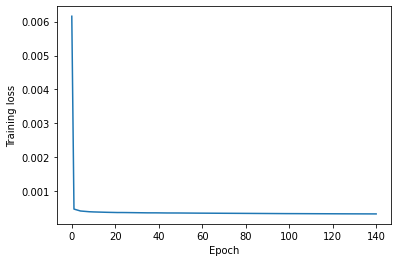

In [0]:
plt.plot(model_1.history.history['loss'])
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.show()

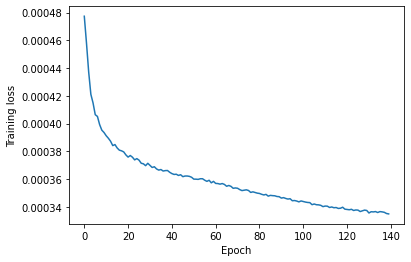

In [0]:
plt.plot(model_1.history.history['loss'][1:])
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.show()

In [0]:
batch = 128

for k in range(0,50):
    model_1 = Sequential()
    model_1.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_1.add(LSTM(24, return_sequences=True))
    model_1.add(LSTM(24))
    model_1.add(Dense(pred_window))

    model_1.compile(optimizer='adam', loss='mean_squared_error')
    model_1.fit(X_train, Y_train, batch_size=batch, epochs=25, validation_data=(X_test, Y_test))

    pred_1 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_1.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_1 = np.append(pred_1, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window1_scaled_new/{k}.csv'.format(k=k), pred_1, delimiter=',', fmt='%10.5f')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 223500 samples, validate on 39455 samples
Epoch 1/25
223500/223500 [==============================] - 54s 241us/step - loss: 0.0041 - val_loss: 4.9232e-04
Epoch 2/25
223500/223500 [==============================] - 52s 235us/step - loss: 4.7551e-04 - val_loss: 5.5627e-04
Epoch 3/25
223500/223500 [==============================] - 53s 238us/step - loss: 4.4005e-04 - val_loss: 5.6382e-04
Epoch 4/25
223500/223500 [==============================] - 53s 239us/step - loss: 4.2615e-04 - val_loss: 4.2078e-04
Epoch 5/25
223500/223500 [==============================] - 53s 239us/step - loss: 4.0931e-04 - val_loss: 3.9051e-04
Epoch 6/25
223500/223500 [==============================] - 53s 239us/step - loss: 4.0084e-04 - val_loss: 4.1649e-04
Epoch 7/25
223500/223500 [==============================] - 53s 237us/step - loss: 3.9673e-04 - val_loss: 3.9426e-04
Epoch 8/25
223500/223500 [==========================

In [0]:
predictions1_scaled = np.zeros((27,Y_test.shape[0]*Y_test.shape[1]))
for k in range(27):
    predictions1_scaled[k] = np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window1_scaled_new/{k}.csv'.format(k=k), delimiter=',')


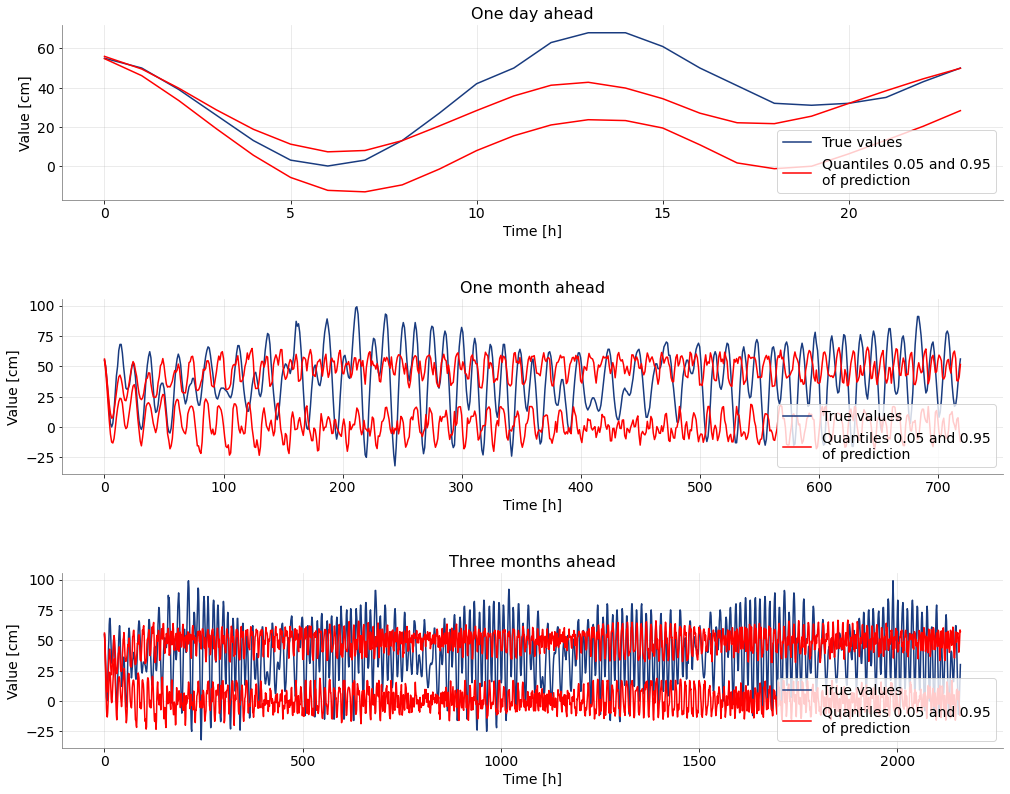

What part of real values lies between quantile lines:
In the first 1 hours (prediction window):  1.0
In the first 12 hours:  0.5833333333333334
In the first 24 hours:  0.375
In the first 48 hours:  0.5416666666666666
For the first month:  0.48333333333333334
For the first year:  0.5679223744292238


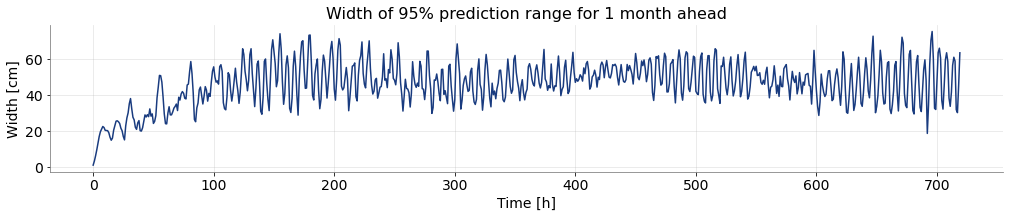

Average width of 95.0 % predinction range:
In the first 1 hours (prediction window):  1.1676390000000012
In the first 12 hours:  14.734825999999998
In the first 24 hours:  17.903700624999995
In the first 48 hours:  21.866642749999997
For the first month:  46.40751357499999
For the first year:  48.757436058904105


In [0]:
see_between_quantiles(scaler.inverse_transform(Y_test), scaler.inverse_transform(predictions1_scaled), 0.95, '1pred_win')

### window independent from seasonality (3 layer nn)


In [0]:
look_back = 4*8
pred_window = 8
train = df_scaled[:223512+pred_window]
test = df_scaled[(223512-look_back):]
X_train, Y_train = create_dataset(np.array(train['lvl']), look_back=look_back, pred_window=pred_window)
X_test, Y_test = create_dataset(np.array(test['lvl']), look_back=look_back, pred_window=pred_window)

In [0]:
batch = 64
 
for k in range(1,50):
    model_15 = Sequential()
    model_15.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_15.add(LSTM(24, return_sequences=True))
    model_15.add(LSTM(24))
    model_15.add(Dense(pred_window))
 
    model_15.compile(optimizer='adam', loss='mean_squared_error')
    model_15.fit(X_train, Y_train, batch_size=batch, epochs=20, validation_data=(X_test, Y_test))
 
    pred_15 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_15.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_15 = np.append(pred_15, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window8_scaled/{k}.csv'.format(k=k), pred_15, delimiter=',', fmt='%10.5f')

Train on 27935 samples, validate on 4931 samples
Epoch 1/20
27935/27935 [==============================] - 23s 830us/step - loss: 0.0192 - val_loss: 0.0069
Epoch 2/20
27935/27935 [==============================] - 22s 802us/step - loss: 0.0070 - val_loss: 0.0064
Epoch 3/20
27935/27935 [==============================] - 22s 801us/step - loss: 0.0063 - val_loss: 0.0058
Epoch 4/20
27935/27935 [==============================] - 23s 813us/step - loss: 0.0061 - val_loss: 0.0052
Epoch 5/20
27935/27935 [==============================] - 23s 814us/step - loss: 0.0056 - val_loss: 0.0054
Epoch 6/20
27935/27935 [==============================] - 23s 815us/step - loss: 0.0053 - val_loss: 0.0050
Epoch 7/20
27935/27935 [==============================] - 23s 819us/step - loss: 0.0050 - val_loss: 0.0045
Epoch 8/20
27935/27935 [==============================] - 23s 818us/step - loss: 0.0047 - val_loss: 0.0042
Epoch 9/20
27935/27935 [==============================] - 23s 815us/step - loss: 0.0043 - val_l

In [0]:
predictions8_scaled = np.zeros((30,Y_test.shape[0]*Y_test.shape[1]))
for k in range(30):
    predictions8_scaled[k] = np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window8_scaled/{k}.csv'.format(k=k), delimiter=',')


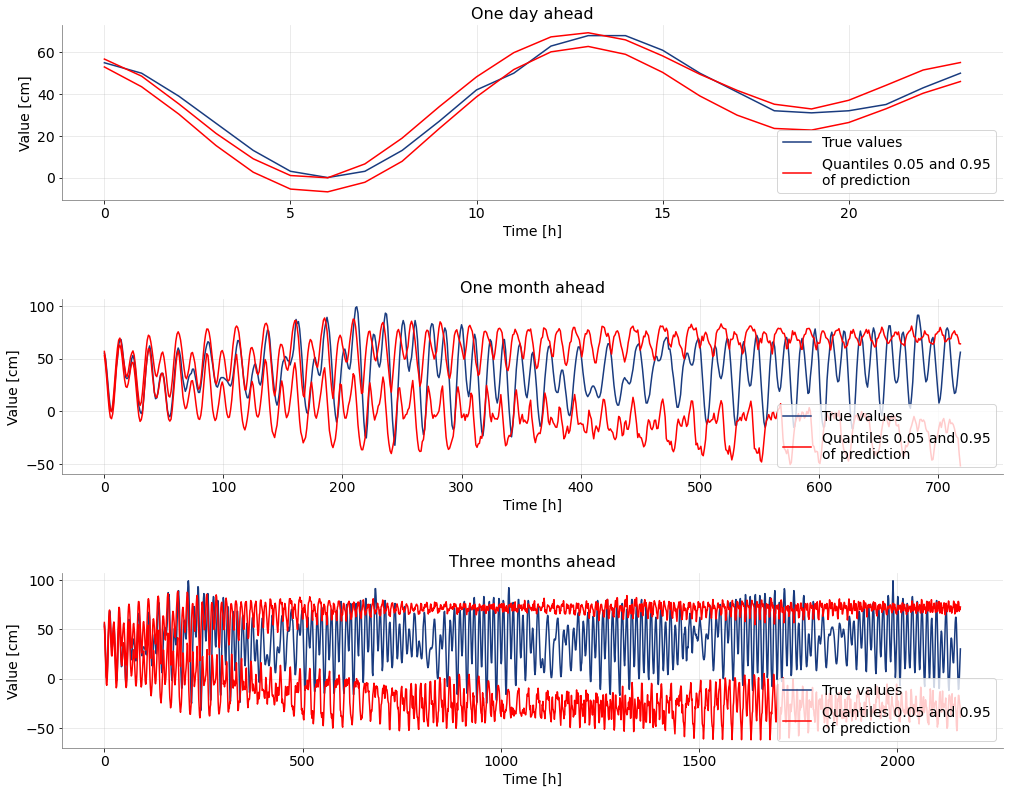

What part of real values lies between quantile lines:
In the first 8 hours (prediction window):  0.25
In the first 12 hours:  0.4166666666666667
In the first 24 hours:  0.5833333333333334
In the first 48 hours:  0.7083333333333334
For the first month:  0.7555555555555555
For the first year:  0.866324200913242


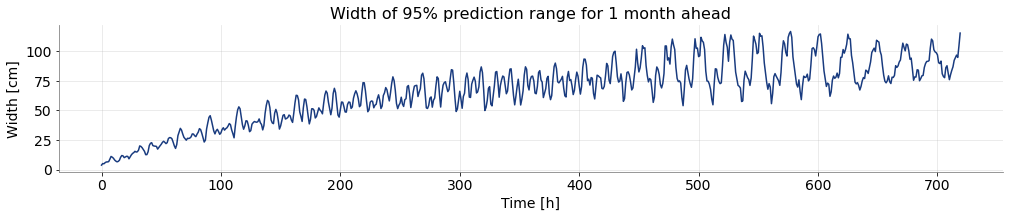

Average width of 95.0 % predinction range:
In the first 8 hours (prediction window):  6.0015774375
In the first 12 hours:  7.271252624999999
In the first 24 hours:  8.412974499999997
In the first 48 hours:  12.660041499999997
For the first month:  65.99414854583331
For the first year:  96.77872314143833


In [0]:
see_between_quantiles(scaler.inverse_transform(Y_test), scaler.inverse_transform(predictions8_scaled), 0.95, '8pred_win')

### bigger look back window


In [0]:
look_back = 360
pred_window = 12
train = df_scaled[:223512+pred_window]
test = df_scaled[(223512-look_back):]
X_train, Y_train = create_dataset(np.array(train['lvl']), look_back=look_back, pred_window=pred_window)
X_test, Y_test = create_dataset(np.array(test['lvl']), look_back=look_back, pred_window=pred_window)

In [0]:
batch = 64
 
for k in range(44,50):
    model_12 = Sequential()
    model_12.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_12.add(LSTM(24, return_sequences=True))
    model_12.add(LSTM(24))
    model_12.add(Dense(pred_window))
 
    model_12.compile(optimizer='adam', loss='mean_squared_error')
    model_12.summary()
    model_12.fit(X_train, Y_train, batch_size=batch, epochs=20, validation_data=(X_test, Y_test))
 
    pred_12 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_12.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_12 = np.append(pred_12, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_biggerlookback/{k}.csv'.format(k=k), pred_12, delimiter=',', fmt='%10.5f')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 360, 48)           9600      
_________________________________________________________________
lstm_2 (LSTM)                (None, 360, 24)           7008      
_________________________________________________________________
lstm_3 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                300       
Total params: 21,612
Trainable params: 21,612
Non-trainable params: 0
_________________________________________________________________

Train on 18596 samples, validate on 3287 samples
Epoch 1/20
18596/18596 [==============================] - 154s 8ms/step - loss: 0.0274 - val_loss: 0.0160
Epoch 2/20


KeyboardInterrupt: ignored

In [0]:
predictions12_scaled = np.zeros((44,Y_test.shape[0]*Y_test.shape[1]))
for k in range(44):
    predictions12_scaled[k] = np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_biggerlookback/{k}.csv'.format(k=k), delimiter=',')
predictions12_scaled = scaler.inverse_transform(predictions12_scaled)

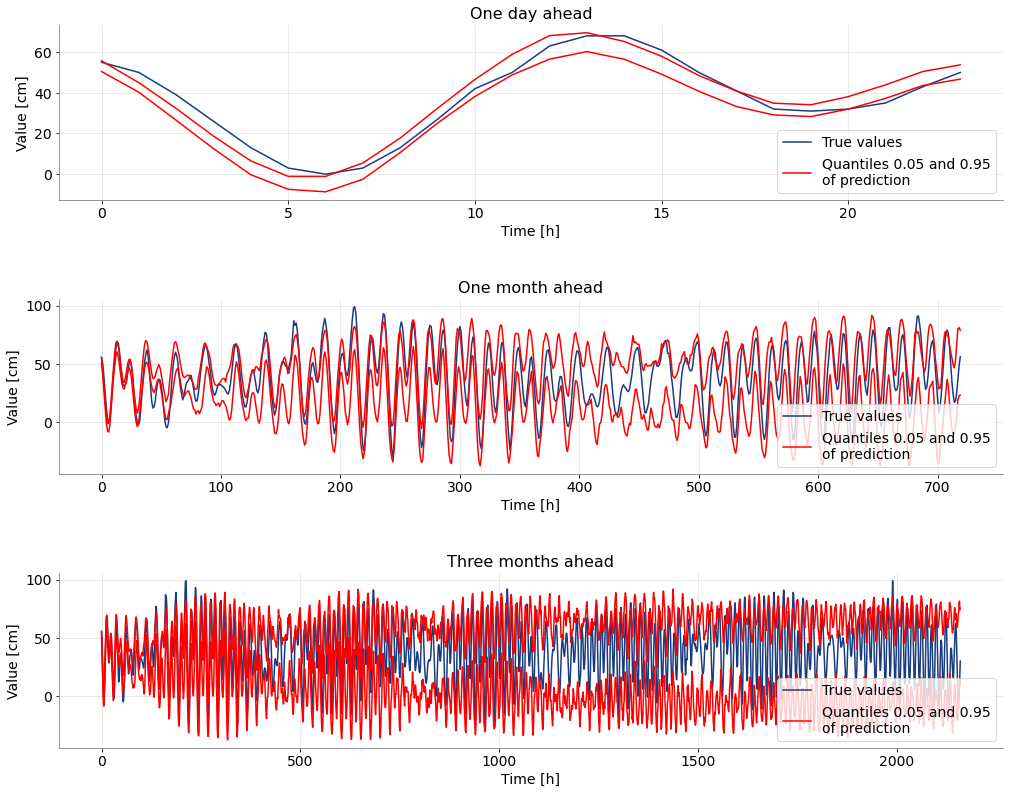

What part of real values lies between quantile lines:
In the first 12 hours (prediction window):  0.5
In the first 12 hours:  0.5
In the first 24 hours:  0.5
In the first 48 hours:  0.5
For the first month:  0.7861111111111111
For the first year:  0.8123287671232877


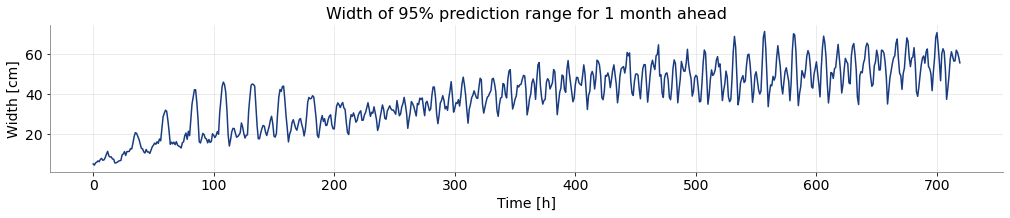

Average width of 95.0 % predinction range:
In the first 12 hours (prediction window):  6.969164624999999
In the first 12 hours:  6.969164624999999
In the first 24 hours:  7.3195583125
In the first 48 hours:  10.3824325625
For the first month:  38.950000768749995
For the first year:  69.8064464255137


In [0]:
see_between_quantiles(scaler.inverse_transform(Y_test), predictions12_scaled, 0.95, '360look_back')

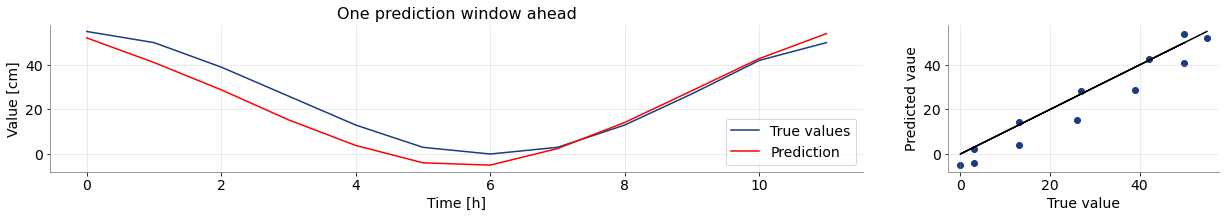

Mean squared error for first single window prediction:  40.24307805332508


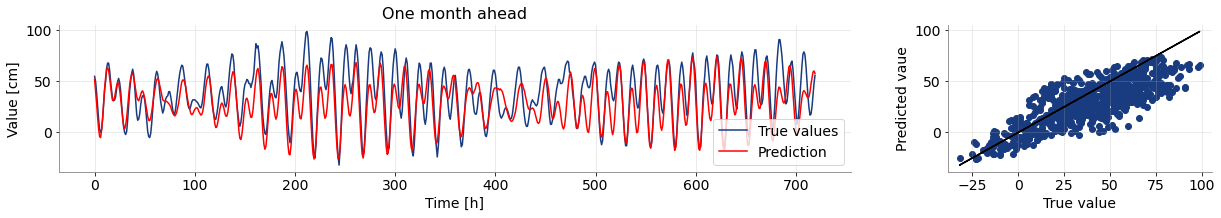

Mean squared error for one month prediction:  326.7582311758959


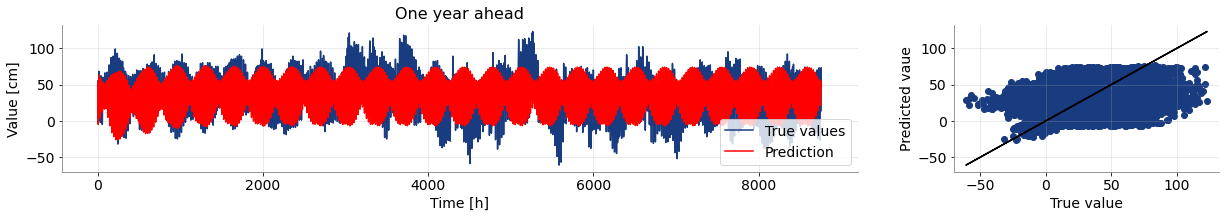

Mean squared error for one year prediction:  891.8540513036343


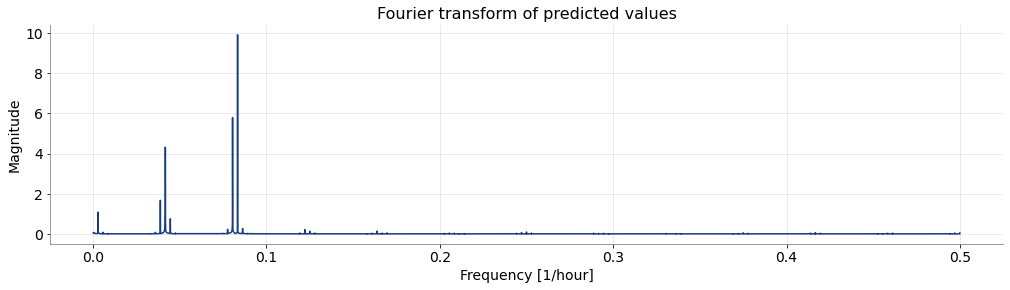

most significant periods obtained - in hours:
 [ 12.          12.43113772  24.00730371  23.99270073  12.42722117
  25.78039216  24.02192448  12.43505675  23.9781155  346.
  12.42330709  24.03656307  12.43897824  22.44963005  24.05121951
  23.963548    12.41939547  24.06589384  12.44290221  24.08058608
 349.0619469   23.94899818  12.41548631  12.44682865]
- in days:
 [ 0.5         0.51796407  1.00030432  0.99969586  0.51780088  1.07418301
  1.00091352  0.51812736  0.99908815 14.41666667  0.5176378   1.00152346
  0.51829076  0.93540125  1.00213415  0.99848117  0.51747481  1.00274558
  0.51845426  1.00335775 14.54424779  0.99787492  0.51731193  0.51861786]
indices:
 [3287 3173 1643 1644 3174 1530 1642 3172 1645  114 3175 1641 3171 1757
 1640 1646 3176 1639 3170 1638  113 1647 3177 3169]


In [0]:
accuracy(scaler.inverse_transform(Y_test), predictions12_scaled[4])

One trial with much more complex network for 360 look back

In [0]:
batch = 64

model_12 = Sequential()
model_12.add(LSTM(96, input_shape=(look_back,1), return_sequences=True))
model_12.add(LSTM(64, return_sequences=True))
model_12.add(LSTM(64, return_sequences=True))
model_12.add(LSTM(32, return_sequences=True))
model_12.add(LSTM(24, return_sequences=True))
model_12.add(LSTM(24, return_sequences=True))
model_12.add(LSTM(12))
model_12.add(Dense(pred_window))

model_12.compile(optimizer='adam', loss='mean_squared_error')
model_12.summary()
model_12.fit(X_train, Y_train, batch_size=batch, epochs=10, validation_data=(X_test, Y_test))

pred_12 = []
x = X_test[[0]]
for i in range(len(Y_test)):
    p = model_12.predict(x)
    x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
    pred_12 = np.append(pred_12, p)

np.savetxt('/content/drive/My Drive/__MGR/most_complex_model.csv', pred_12, delimiter=',', fmt='%10.5f')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 360, 96)           37632     
_________________________________________________________________
lstm_5 (LSTM)                (None, 360, 64)           41216     
_________________________________________________________________
lstm_6 (LSTM)                (None, 360, 64)           33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 360, 32)           12416     
_________________________________________________________________
lstm_8 (LSTM)                (None, 360, 24)           5472      
_________________________________________________________________
lstm_9 (LSTM)                (None, 360, 24)           4704      
_________________________________________________________________
lstm_10 (LSTM)               (None, 12)               

In [0]:
predictions12_complex = np.zeros((1,Y_test.shape[0]*Y_test.shape[1]))
for k in range(1):
    predictions12_complex[k] = np.genfromtxt('/content/drive/My Drive/__MGR/most_complex_model.csv', delimiter=',')
predictions12_complex = scaler.inverse_transform(predictions12_complex)

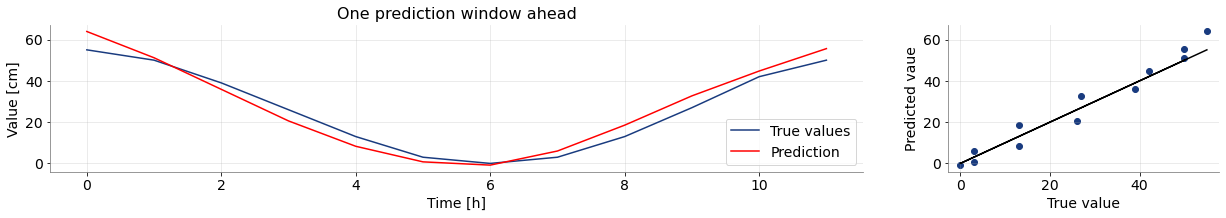

Mean squared error for first single window prediction:  21.538800243524943


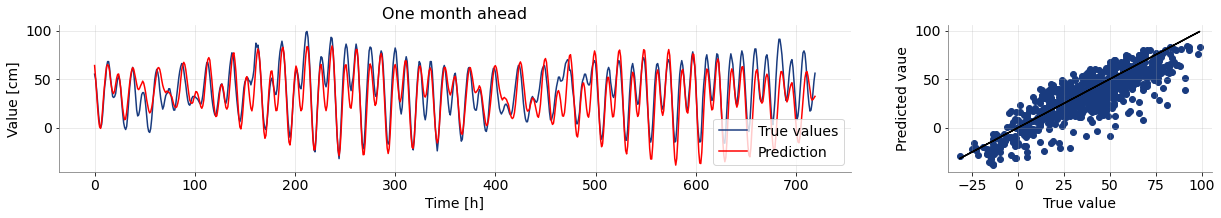

Mean squared error for one month prediction:  230.89420954798916


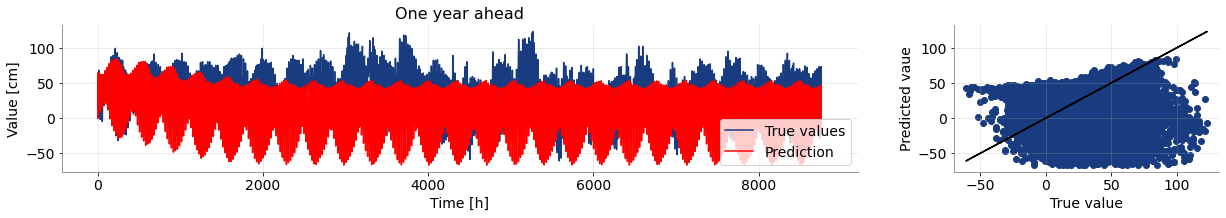

Mean squared error for one year prediction:  2413.24623744301


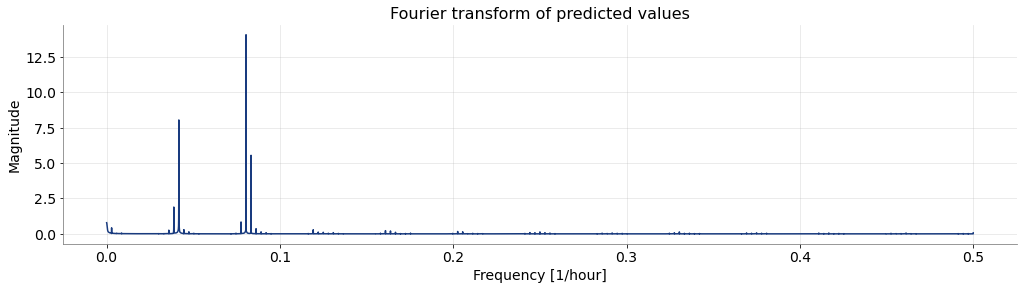

most significant periods obtained - in hours:
 [   23.99270073    24.00730371            inf    12.
    23.9781155     24.02192448    25.79725311    23.963548
    24.03656307    25.78039216    23.94899818    24.05121951
    12.43505675    23.93446602    12.89440994    24.06589384
    23.91995149 39444.         19722.         13148.
  9861.          7888.8           12.42722117  6574.        ]
- in days:
 [   0.99969586    1.00030432           inf    0.5           0.99908815
    1.00091352    1.07488555    0.99848117    1.00152346    1.07418301
    0.99787492    1.00213415    0.51812736    0.99726942    0.53726708
    1.00274558    0.99666465 1643.5         821.75        547.83333333
  410.875       328.7           0.51780088  273.91666667]
indices:
 [1644 1643    0 3287 1645 1642 1529 1646 1641 1530 1647 1640 3172 1648
 3059 1639 1649    1    2    3    4    5 3174    6]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: divide by zero encountered in true_divide


In [0]:
accuracy(scaler.inverse_transform(Y_test), predictions12_complex[0])

### smaller look back window

In [0]:
look_back = 1
pred_window = 1
train = df_scaled[:223512+pred_window]
test = df_scaled[(223512-look_back):]
X_train, Y_train = create_dataset(np.array(train['lvl']), look_back=look_back, pred_window=pred_window)
X_test, Y_test = create_dataset(np.array(test['lvl']), look_back=look_back, pred_window=pred_window)

In [0]:
batch = 64
 
model_small = Sequential()
model_small.add(LSTM(360, input_shape=(look_back,1), return_sequences=True))
model_small.add(LSTM(24, return_sequences=True))
model_small.add(LSTM(24))
model_small.add(Dense(pred_window))

model_small.compile(optimizer='adam', loss='mean_squared_error')
model_small.summary()
model_small.fit(X_train, Y_train, batch_size=batch, epochs=20, validation_data=(X_test, Y_test))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 360)            521280    
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 24)             36960     
_________________________________________________________________
lstm_6 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 562,969
Trainable params: 562,969
Non-trainable params: 0
_________________________________________________________________
Train on 223511 samples, validate on 39455 samples
Epoch 1/20
223511/223511 [==============================] - 67s 298us/step - loss: 0.0088 - val_loss: 0.0079
Epoch 2/20
223511/223511 [==============================] - 62s 278us/step - loss: 0.0

In [0]:
pred_small = []
x = X_test[[0]]
for i in range(len(Y_test)):
    p = model_small.predict(x)
    x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
    pred_small = np.append(pred_small, p)

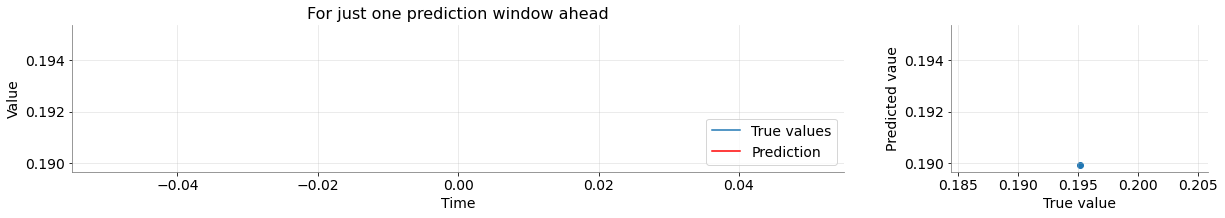

Mean squared error for first single window prediction:  2.7158589621710468e-05


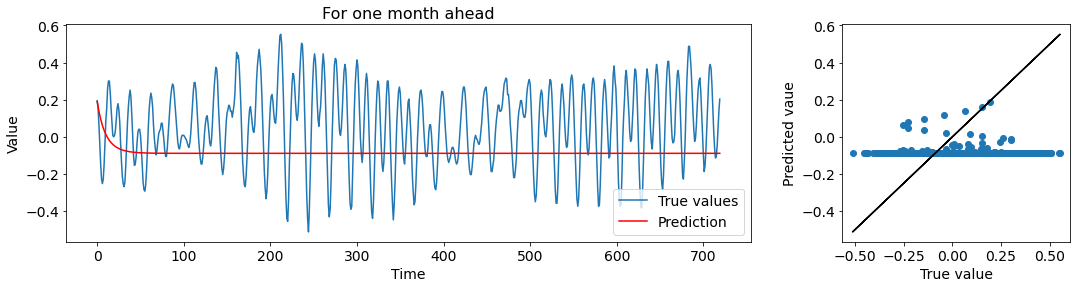

Mean squared error for one month prediction:  0.06542988215232742


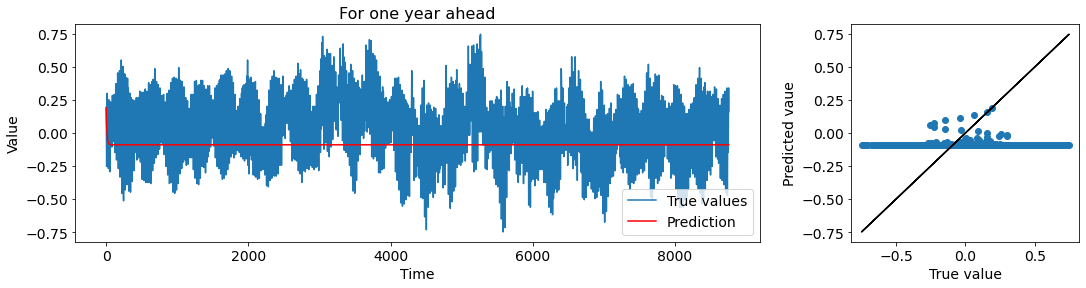

Mean squared error for one year prediction:  0.06855500013240469


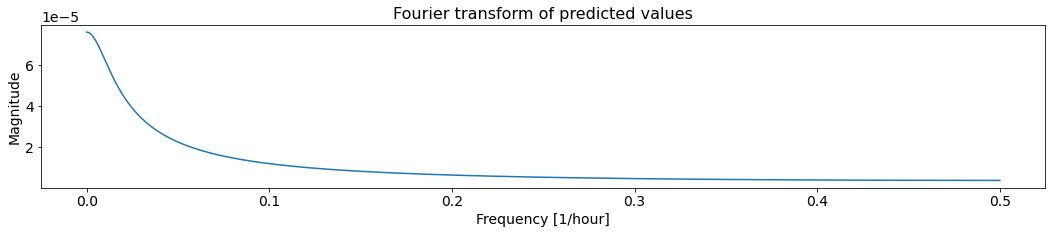

most significant periods obtained - in hours:
 [39455.         19727.5        13151.66666667  9863.75
  7891.          6575.83333333  5636.42857143  4931.875
  4383.88888889  3945.5         3586.81818182  3287.91666667
  3035.          2818.21428571  2630.33333333  2465.9375
  2320.88235294  2191.94444444  2076.57894737  1972.75
  1878.80952381  1793.40909091  1715.43478261  1643.95833333]
- in days:
 [1643.95833333  821.97916667  547.98611111  410.98958333  328.79166667
  273.99305556  234.85119048  205.49479167  182.66203704  164.39583333
  149.45075758  136.99652778  126.45833333  117.42559524  109.59722222
  102.74739583   96.70343137   91.33101852   86.52412281   82.19791667
   78.28373016   74.72537879   71.47644928   68.49826389]
indices:
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [0]:
accuracy(Y_test, pred_small)